In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
from scipy.interpolate import interp1d
from utils_CR import CR

# DATA EXTRACTION

In [2]:
FILE = 'C:/Users/pedro/OneDrive/Escritorio/run_2D_DRAGON2_BC_Source_spectrum.fits.gz'
print(FILE)

hdulist = fits.open(FILE) 
#hdulist.info() 
prihdr = hdulist[0].header  # the primary header 
n_ext  = len(hdulist)


table_hdu    = hdulist[0]              
table_header = table_hdu.header     # header attribute of TABLE 
'''
zmin   = table_header['zmin']
zmax   = table_header['zmax']
rmin   = table_header['rmin']
rmax   = table_header['rmax']
izsun  = table_header['izsun']
irsun  = table_header['irsun']
dimz   = table_header['dimz']
dimr   = table_header['dimr']
robs   = table_header['robs']
zobs   = table_header['zobs']
'''
emin   = table_header['ekmin']
ek_fac = table_header['ekin_fac']
dimE   = table_header['dimE'] 

E = [emin*(ek_fac**i) for i in range(0,dimE)]
E = np.array(E)

table_H1_P, table_H1_S, table_H2, table_H3, table_He4, table_He3, table_C12, table_C13, table_C14, table_N14, table_N15, table_O16, table_O17, table_O18, table_Ne, table_Mg, table_Si = [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []
table_Li6, table_Li7, table_Be7, table_Be9, table_Be10, table_B10, table_B11 = [], [], [], [], [], [], []
for i in range(1,n_ext): #points in the list         

    ## Main CRs
    if hdulist[i].header['A'] == 12 and hdulist[i].header['Z_'] == 6 :
        table_C12.append(hdulist[i].data)
    elif hdulist[i].header['A'] == 13 and hdulist[i].header['Z_'] == 6 :
        table_C13.append(hdulist[i].data)
    elif hdulist[i].header['A'] == 14 and hdulist[i].header['Z_'] == 6 :
        table_C14.append(hdulist[i].data)
        
    elif hdulist[i].header['A'] == 14 and hdulist[i].header['Z_'] == 7 :
        table_N14.append(hdulist[i].data)
    elif hdulist[i].header['A'] == 15 and hdulist[i].header['Z_'] == 7 :
        table_N15.append(hdulist[i].data)
        
    elif hdulist[i].header['A'] == 16 and hdulist[i].header['Z_'] == 8 :
        table_O16.append(hdulist[i].data)
    elif hdulist[i].header['A'] == 17 and hdulist[i].header['Z_'] == 8 :
        table_O17.append(hdulist[i].data)
    elif hdulist[i].header['A'] == 18 and hdulist[i].header['Z_'] == 8 :
        table_O18.append(hdulist[i].data)

    elif hdulist[i].header['A'] == 20 and hdulist[i].header['Z_'] == 10:
        table_Ne.append(hdulist[i].data)
    elif hdulist[i].header['A'] == 24 and hdulist[i].header['Z_'] == 12:
        table_Mg.append(hdulist[i].data)
    elif hdulist[i].header['A'] == 28 and hdulist[i].header['Z_'] == 14:
        table_Si.append(hdulist[i].data)
        
    elif hdulist[i].header['A'] == 1 and hdulist[i].header['Z_'] == 1 and hdulist[i].header['SEC'] == 0 :
        table_H1_P.append(hdulist[i].data)
    elif hdulist[i].header['A'] == 1 and hdulist[i].header['Z_'] == 1 and hdulist[i].header['SEC'] == 1 :
        table_H1_S.append(hdulist[i].data)
    elif hdulist[i].header['A'] == 2 and hdulist[i].header['Z_'] == 1 :
        table_H2.append(hdulist[i].data)
    elif hdulist[i].header['A'] == 3 and hdulist[i].header['Z_'] == 1 :
        table_H3.append(hdulist[i].data)
        
    elif hdulist[i].header['A'] == 4 and hdulist[i].header['Z_'] == 2 :
        table_He4.append(hdulist[i].data)
    elif hdulist[i].header['A'] == 3 and hdulist[i].header['Z_'] == 2 :
        table_He3.append(hdulist[i].data)
        
    ## LiBeB group
    elif hdulist[i].header['A'] == 10 and hdulist[i].header['Z_'] == 5 :
        table_B10.append(hdulist[i].data)
    elif hdulist[i].header['A'] == 11 and hdulist[i].header['Z_'] == 5 :
        table_B11.append(hdulist[i].data)
            
    elif hdulist[i].header['A'] == 7 and hdulist[i].header['Z_'] == 4 :
        table_Be7.append(hdulist[i].data)
    elif hdulist[i].header['A'] == 9 and hdulist[i].header['Z_'] == 4 :
        table_Be9.append(hdulist[i].data)
    elif hdulist[i].header['A'] == 10 and hdulist[i].header['Z_'] == 4 :
        table_Be10.append(hdulist[i].data)
            
    elif hdulist[i].header['A'] == 6 and hdulist[i].header['Z_'] == 3 :
        table_Li6.append(hdulist[i].data)
    elif hdulist[i].header['A'] == 7 and hdulist[i].header['Z_'] == 3 :
        table_Li7.append(hdulist[i].data)
        

table_H1 = np.array(table_H1_P + table_H1_S)

C:/Users/pedro/OneDrive/Escritorio/run_2D_DRAGON2_BC_Source_spectrum.fits.gz


In [4]:
phi_ams = 0.54  ## Fisk potential adopted to make the plots 

#params for the plots
widths = [1]
heights = [2.8,1.]
gs_kw = dict(width_ratios=widths, height_ratios=heights)

## For Voyager data
def voyerr(a, b, da, db):
    if ((type(a) != np.ndarray) or (type(b) != np.ndarray) or 
        (type(da) != np.ndarray) or (type(db) != np.ndarray)):
        print("Error, the Fluxes (Energies) and errFluxes (ErrEnergies) must be an array")
    return np.sqrt((da/b)**2 + (-a*db/b**2)**2)

# He & H data

In [5]:
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/prot&Hel/prot_AMS_2011-2013.dat'
Emeanp, Emeanp_low, Emeanp_up = np.loadtxt(data,skiprows=0,usecols=(0, 1, 2), unpack=True)
fluxp, fluxp_low, fluxp_up = np.loadtxt(data,skiprows=0,usecols=(3, 8, 9), unpack=True)
errfluxp = (fluxp_low + fluxp_up)/2

data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/prot&Hel/p_flux_ATIC2009.txt'
EmeanAT, EmeanAT_low, EmeanAT_up = np.loadtxt(data,skiprows=0,usecols=(0, 1, 2), unpack=True)
fluxAT, fluxAT_low, fluxAT_up = np.loadtxt(data,skiprows=0,usecols=(3, 4, 5), unpack=True)
errfluxAT = (fluxAT_low + fluxAT_up)/2

data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/prot&Hel/p_flux_CREAMIII_ApJ2017.txt'
EmeanCR, EmeanCR_low, EmeanCR_up = np.loadtxt(data,skiprows=0,usecols=(0, 1, 2), unpack=True)
fluxCR, fluxCR_low, fluxCR_up = np.loadtxt(data,skiprows=0,usecols=(3, 4, 5), unpack=True)
errfluxCR = (fluxCR_low + fluxCR_up)/2

data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/prot&Hel/DAMPE_protons.txt'
EmeanDA, EmeanDA_low, EmeanDA_up = np.loadtxt(data,skiprows=1,usecols=(1, 0, 2), unpack=True)
fluxDA, fluxDA_low, fluxDA_up = np.loadtxt(data,skiprows=1,usecols=(4, 3, 5), unpack=True)
errfluxDA = (fluxDA_low + fluxDA_up)/2



data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/prot&Hel/He_AMS_2011-2013.dat'
EmeanHe, EmeanHe_low, EmeanHe_up = np.loadtxt(data,skiprows=0,usecols=(0, 1, 2), unpack=True)
fluxHe, fluxHe_low, fluxHe_up = np.loadtxt(data,skiprows=0,usecols=(3, 8, 9), unpack=True)
errfluxHe = (fluxHe_low + fluxHe_up)/2

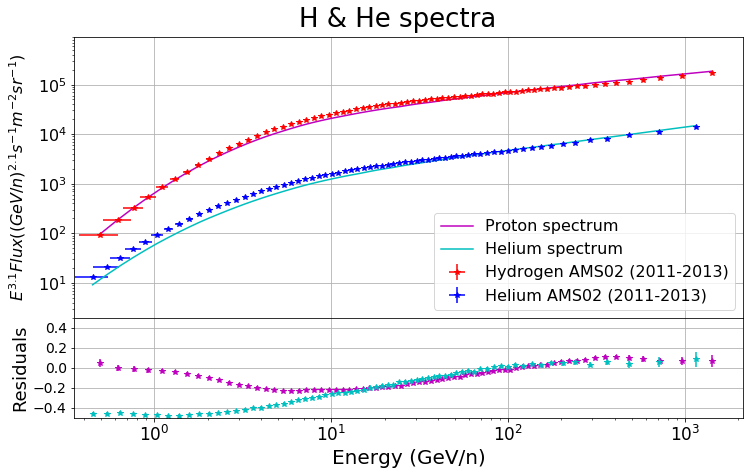

In [6]:
fig1, (frame1,frame2)=plt.subplots(2, sharex='col', figsize=(12,7), gridspec_kw=gs_kw)
fig1.suptitle("H & He spectra", fontsize = 26, y=0.94)
    
fig1.subplots_adjust(hspace=0.)
frame1.set_yscale('log')
frame1.set_xscale('log', nonposx = 'clip')

frame1.errorbar(Emeanp, fluxp*np.power(Emeanp, 3.1), xerr = [(Emeanp-Emeanp_low)/Emeanp, (Emeanp_up-Emeanp)/Emeanp], yerr = [fluxp_low*np.power(Emeanp, 3.1), fluxp_up*np.power(Emeanp, 3.1)], fmt= '*r', label = "Hydrogen AMS02 (2011-2013)") #Real data

frame1.errorbar(EmeanHe, fluxHe*np.power(EmeanHe, 3.1), xerr = [(EmeanHe-EmeanHe_low)/EmeanHe, (EmeanHe_up-EmeanHe)/EmeanHe], yerr = [fluxHe_low*np.power(EmeanHe, 3.1), fluxHe_up*np.power(EmeanHe, 3.1)], fmt= '*b', label = "Helium AMS02 (2011-2013)") #Real data

H1 = np.interp(Emeanp, E, CR.modul(E, np.array(table_H1)[0], 1, 1, phi_ams))
H2 = np.interp(Emeanp, E, CR.modul(E, np.array(table_H2)[0], 1, 2, phi_ams))
H3 = np.interp(Emeanp, E, CR.modul(E, np.array(table_H3)[0], 1, 3, phi_ams))

mod0 = H1 + H2 + H3

frame1.plot(Emeanp, mod0*(Emeanp**3.1), "m-", label='Proton spectrum')

He3 = np.interp(EmeanHe, E, CR.modul(E, np.array(table_He3)[0], 2, 3, phi_ams))
He4 = np.interp(EmeanHe, E, CR.modul(E, np.array(table_He4)[0], 2, 4, phi_ams))

mod1 = He4 + He3

frame1.plot(EmeanHe, mod1*(EmeanHe**3.1), "c-", label='Helium spectrum')


frame1.set_ylabel(r"$E^{3.1} Flux ((GeV/n)^{2.1} s^{-1} m^{-2} sr^{-1})$", fontsize = 16, labelpad = 10)
frame1.tick_params(axis = 'y', labelsize=16)
frame1.grid()
frame1.set_ylim(bottom = 2, top = 9e5)
frame1.set_xlim(left = 0.35)#, right = 2000)
frame1.legend(fontsize =16, loc = 4)

frame2.set_xscale("log")

diff = np.array(mod0-fluxp)
frame2.errorbar(Emeanp, diff/mod0, yerr = [(fluxp_up/fluxp), (fluxp_low/fluxp)],  fmt= "m*")

diff = np.array(mod1-fluxHe)
frame2.errorbar(EmeanHe, diff/mod1, yerr = [(fluxHe_up/fluxHe), (fluxHe_low/fluxHe)], fmt= "c*")


frame2.set_ylabel("Residuals", fontsize = 18)
frame2.set_xlabel("Energy (GeV/n)", fontsize = 20)
frame2.set_xlim(left = 0.35)#, right = 1800)
frame2.grid()
plt.xticks(fontsize=17)
plt.yticks(fontsize=14)
frame2.set_ylim(bottom = -0.5, top = 0.5)
#frame2.legend(ncol = 4, loc = 0) #1 is upper right
plt.savefig('C:/Users/pedro/OneDrive/Escritorio/pHe_spectrum_Fluka.png')
plt.savefig('C:/Users/pedro/OneDrive/Escritorio/pHe_spectrum_Fluka.pdf')
plt.show()
plt.close()

# CARBON data

In [7]:
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/BC/C_AMS_PRL2017.txt'
EmeanC, EmeanC_low, EmeanC_up = np.loadtxt(data,skiprows=0,usecols=(0, 1, 2), unpack=True)
fluxC, fluxC_low, fluxC_up = np.loadtxt(data,skiprows=0,usecols=(3, 4, 5), unpack=True)
errfluxC = (fluxC_low + fluxC_up)/2

myZ = 6
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/BC/apjaa2409t9_ascii.txt' 
Z, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)
fluxA, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)
EmeanA = (1e-3*(0.5*(Emean_min + Emean_max)))[Z == myZ]
errfluxA = np.sqrt(sys**2 + sig**2)[Z==myZ]
fluxA = 1e3*fluxA[Z==myZ]

Emean_min = (1e-3 * Emean_min[Z==myZ])
Emean_max = (1e-3 * Emean_max[Z==myZ])

Emean_min = EmeanA - Emean_min
Emean_max = Emean_max - EmeanA

EmeanA = EmeanA


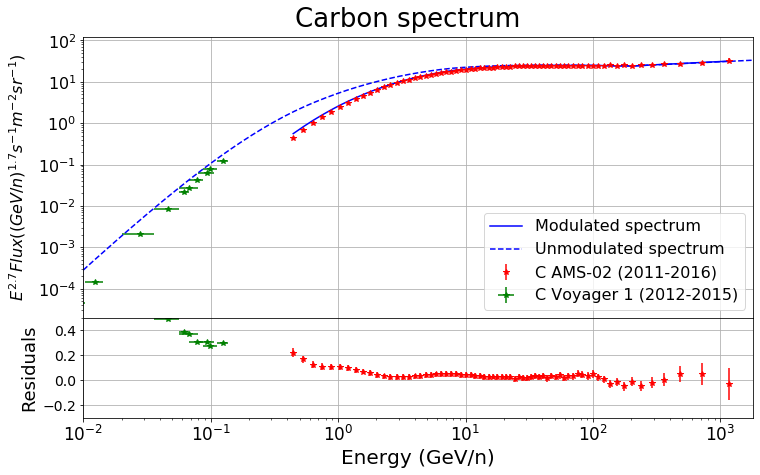

In [8]:
fig1, (frame1,frame2)=plt.subplots(2, sharex='col', figsize=(12,7), gridspec_kw=gs_kw)
fig1.suptitle("Carbon spectrum", fontsize = 26, y=0.94)
    
fig1.subplots_adjust(hspace=0.)
frame1.set_yscale('log')
frame1.set_xscale('log', nonposx = 'clip')

frame1.errorbar(EmeanC, fluxC*np.power(EmeanC, 2.7), yerr = [fluxC_low*np.power(EmeanC, 2.7), fluxC_up*np.power(EmeanC, 2.7)], fmt= '*r', label = "C AMS-02 (2011-2016)") #Real data
frame1.errorbar(EmeanA, fluxA*np.power(EmeanA, 2.7), xerr = [Emean_min, Emean_max], yerr = errfluxA*np.power(EmeanA, 2.7), fmt= '*g', label = "C Voyager 1 (2012-2015)") #Real data
C12 = np.interp(EmeanC, E, CR.modul(E, np.array(table_C12)[0], myZ, 12, phi_ams))
C13 = np.interp(EmeanC, E, CR.modul(E, np.array(table_C13)[0], myZ, 13, phi_ams))
C14 = np.interp(EmeanC, E, CR.modul(E, np.array(table_C14)[0], myZ, 14, phi_ams))
#C12 = interp1d(E, CR.modul(E, np.array(table_C12)[0], myZ, 12, phi_ams), 'cubic')
#C13 = interp1d(E, CR.modul(E, np.array(table_C13)[0], myZ, 13, phi_ams), 'cubic')
#C14 = interp1d(E, CR.modul(E, np.array(table_C14)[0], myZ, 14, phi_ams), 'cubic')

mod0 = C12 + C13 + C14
#mod0 = C12(EmeanC) + C13(EmeanC) + C14(EmeanC)

frame1.plot(EmeanC, mod0*(EmeanC**2.7), "b-", label='Modulated spectrum')

mod1 = np.interp(E, E, (np.array(table_C12) + np.array(table_C13) + np.array(table_C14))[0])
frame1.plot(E, mod1*(E**2.7), "b--", label='Unmodulated spectrum')

frame1.set_ylabel(r"$E^{2.7} Flux ((GeV/n)^{1.7} s^{-1} m^{-2} sr^{-1})$", fontsize = 16, labelpad = 10)
frame1.tick_params(axis = 'y', labelsize=16)
frame1.grid()
frame1.set_ylim(2*1e-5)
frame1.set_xlim(left = 0.001, right = 2000)
frame1.legend(fontsize =16, loc = 4)

frame2.set_xscale("log")

diff = np.array(mod0-fluxC)
frame2.errorbar(EmeanC, diff/mod0, yerr = [(fluxC_up/fluxC), (fluxC_low/fluxC)],  fmt= "r*")

mod1 = np.interp(EmeanA, E, mod1)
diff = np.array(mod1-fluxA)
frame2.errorbar(EmeanA, diff/mod1, yerr = errfluxA/fluxA, xerr = [Emean_min, Emean_max],  fmt= "g*")


frame2.set_ylabel("Residuals", fontsize = 18)
frame2.set_xlabel("Energy (GeV/n)", fontsize = 20)
frame2.set_xlim(left = 0.01, right = 1800)
frame2.grid()
plt.xticks(fontsize=17)
plt.yticks(fontsize=14)
frame2.set_ylim(bottom = -0.3, top = 0.5)
#frame2.legend(ncol = 4, loc = 0) #1 is upper right
plt.savefig('C:/Users/pedro/OneDrive/Escritorio/C_spectrum.png')
plt.savefig('C:/Users/pedro/OneDrive/Escritorio/C_spectrum.pdf')
plt.show()
plt.close()

# OXYGEN data

In [9]:
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/nuclei1/O_AMS_PRL2017.txt' 
EmeanO, EmeanO_low, EmeanO_up = np.loadtxt(data,skiprows=0,usecols=(0, 1, 2), unpack=True)
fluxO, fluxO_low, fluxO_up = np.loadtxt(data,skiprows=0,usecols=(3, 4, 5), unpack=True)

errfluxO = (fluxO_low + fluxO_up)/2

myZ = 8
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/BC/apjaa2409t9_ascii.txt' 
Z, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)
fluxA, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)
EmeanA = (1e-3*(0.5*(Emean_min + Emean_max)))[Z == myZ]
errfluxA = np.sqrt(sys**2 + sig**2)[Z==myZ]
fluxA = 1e3*fluxA[Z==myZ]

Emean_min = (1e-3 * Emean_min[Z==myZ])
Emean_max = (1e-3 * Emean_max[Z==myZ])

Emean_min = EmeanA - Emean_min
Emean_max = Emean_max - EmeanA

EmeanA = EmeanA

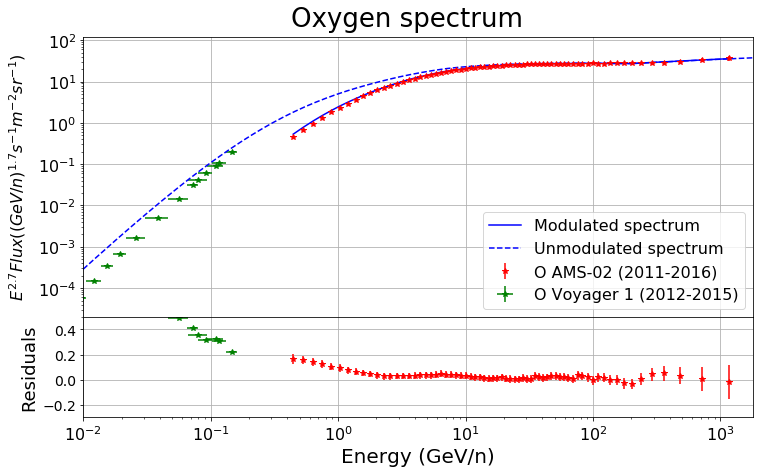

In [10]:
fig1, (frame1,frame2)=plt.subplots(2, sharex='col', figsize=(12,7), gridspec_kw=gs_kw)
fig1.suptitle("Oxygen spectrum", fontsize = 26, y=0.94)
    
fig1.subplots_adjust(hspace=0.)
frame1.set_yscale('log')
frame1.set_xscale('log', nonposx = 'clip')

frame1.errorbar(EmeanO, fluxO*np.power(EmeanO, 2.7), yerr=[fluxO_low*np.power(EmeanO, 2.7), fluxO_up*np.power(EmeanO, 2.7)], fmt= '*r', label = "O AMS-02 (2011-2016)") #Real data
frame1.errorbar(EmeanA, fluxA*np.power(EmeanA, 2.7), xerr=[Emean_min, Emean_max], yerr= errfluxA*np.power(EmeanA, 2.7), fmt= '*g', label = "O Voyager 1 (2012-2015)") #Real data

O16 = np.interp(EmeanO, E, CR.modul(E, np.array(table_O16)[0], myZ, 16, phi_ams))
O17 = np.interp(EmeanO, E, CR.modul(E, np.array(table_O17)[0], myZ, 17, phi_ams))
O18 = np.interp(EmeanO, E, CR.modul(E, np.array(table_O18)[0], myZ, 18, phi_ams))
mod0 = O16 + O17 + O18
frame1.plot(EmeanO, mod0*(EmeanO**2.7), "b-", label='Modulated spectrum')

mod1 = np.interp(E, E, (np.array(table_O16) + np.array(table_O17) + np.array(table_O18))[0])
frame1.plot(E, mod1*(E**2.7), "b--", label='Unmodulated spectrum')

frame1.set_ylabel(r"$E^{2.7} Flux ((GeV/n)^{1.7} s^{-1} m^{-2} sr^{-1})$", fontsize = 16, labelpad = 10)
#plt.yticks(fontsize=28)
frame1.tick_params(axis = 'y', labelsize=16)
frame1.grid()
frame1.set_ylim(2*1e-5)
frame1.set_xlim(left = 0.001, right = 2000)
frame1.legend(fontsize =16, loc = 4)

frame2.set_xscale("log")

diff = np.array(mod0-fluxO)
frame2.errorbar(EmeanO, diff/mod0, yerr = errfluxO/fluxO,  fmt= "r*")

mod1 = np.interp(EmeanA, E, mod1)
diff = np.array(mod1-fluxA)
frame2.errorbar(EmeanA, diff/mod1, yerr = errfluxA/fluxA, xerr = [Emean_min, Emean_max],  fmt= "g*")

frame2.set_ylabel("Residuals", fontsize = 18)
frame2.set_xlabel("Energy (GeV/n)", fontsize = 20)
frame2.set_xlim(left = 0.01, right = 1800)
frame2.grid()
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
frame2.set_ylim(bottom = -0.3, top = 0.5)
#frame2.legend(ncol = 4, loc = 0) #1 is upper right
plt.savefig('C:/Users/pedro/OneDrive/Escritorio/O_spectrum.png')
plt.savefig('C:/Users/pedro/OneDrive/Escritorio/O_spectrum.pdf')
plt.show()
plt.close()

# NITROGEN data

In [11]:
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/nuclei1/N_AMS_PRL2018_rig.txt' 
RmeanN, RmeanN_low, RmeanN_up = np.loadtxt(data,skiprows=0,usecols=(0, 1, 2), unpack=True)
fluxN, fluxN_low, fluxN_up = np.loadtxt(data,skiprows=0,usecols=(3, 4, 5), unpack=True)

errfluxN = (fluxN_low + fluxN_up)/2

EmeanN, fluxN, errfluxN = CR.Rig_to_En(RmeanN, 14.5, 7, fluxN, errfluxN)


myZ = 7
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/BC/apjaa2409t9_ascii.txt' 
Z, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)
fluxA, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)
EmeanA = (1e-3*(0.5*(Emean_min + Emean_max)))[Z == myZ]
errfluxA = np.sqrt(sys**2 + sig**2)[Z==myZ]
fluxA = 1e3*fluxA[Z==myZ]

Emean_min = (1e-3 * Emean_min[Z==myZ])
Emean_max = (1e-3 * Emean_max[Z==myZ])

Emean_min = EmeanA - Emean_min
Emean_max = Emean_max - EmeanA

EmeanA = EmeanA

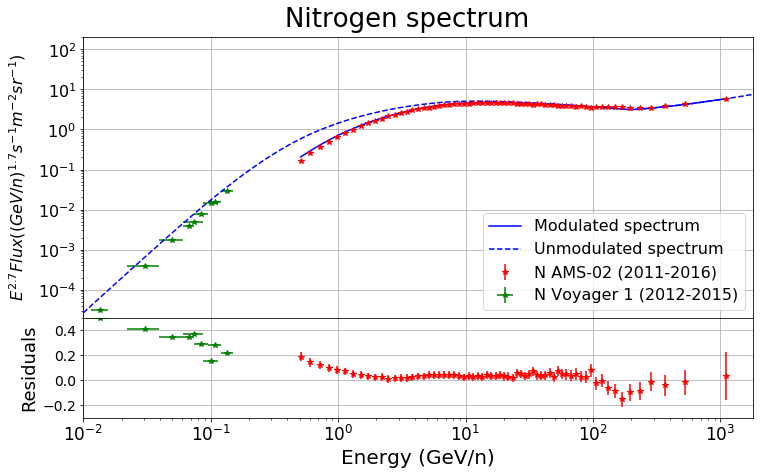

In [12]:
fig1, (frame1,frame2)=plt.subplots(2, sharex='col', figsize=(12,7), gridspec_kw=gs_kw)
fig1.suptitle("Nitrogen spectrum", fontsize = 26, y=0.94)
    
fig1.subplots_adjust(hspace=0.)
frame1.set_yscale('log')
frame1.set_xscale('log', nonposx = 'clip')

frame1.errorbar(EmeanN, fluxN*np.power(EmeanN, 2.7), yerr=[fluxN_low*np.power(EmeanN, 2.7), fluxN_up*np.power(EmeanN, 2.7)], fmt= '*r', label = "N AMS-02 (2011-2016)") #Real data
frame1.errorbar(EmeanA, fluxA*np.power(EmeanA, 2.7), xerr=[Emean_min, Emean_max], yerr= errfluxA*np.power(EmeanA, 2.7), fmt= '*g', label = "N Voyager 1 (2012-2015)") #Real data

N14 = np.interp(EmeanN, E, CR.modul(E, np.array(table_N14)[0], myZ, 14, phi_ams))
N15 = np.interp(EmeanN, E, CR.modul(E, np.array(table_N15)[0], myZ, 15, phi_ams))
mod0 = N14 + N15
frame1.plot(EmeanN, mod0*(EmeanN**2.7), "b-", label='Modulated spectrum')

mod1 = np.interp(E, E, (np.array(table_N14) + np.array(table_N15))[0])
frame1.plot(E, mod1*(E**2.7), "b--", label='Unmodulated spectrum')

frame1.set_ylabel(r"$E^{2.7} Flux ((GeV/n)^{1.7} s^{-1} m^{-2} sr^{-1})$", fontsize = 16, labelpad = 10)
frame1.tick_params(axis = 'y', labelsize=16)
frame1.grid()
frame1.set_ylim(2*1e-5)
frame1.set_xlim(left = 0.001, right = 2000)
frame1.legend(fontsize =16, loc=4)

frame2.set_xscale("log")

diff = np.array(mod0-fluxN)
frame2.errorbar(EmeanN, diff/mod0, yerr = errfluxN/fluxN,  fmt= "r*")

mod1 = np.interp(EmeanA, E, mod1)
diff = np.array(mod1-fluxA)
frame2.errorbar(EmeanA, diff/mod1, yerr = errfluxA/fluxA, xerr = [Emean_min, Emean_max],  fmt= "g*")

frame2.set_ylabel("Residuals", fontsize = 18)
frame2.set_xlabel("Energy (GeV/n)", fontsize = 20)
frame2.set_xlim(left = 0.01, right = 1800)
frame2.grid()
plt.xticks(fontsize=17)
plt.yticks(fontsize=14)
frame2.set_ylim(bottom = -0.3, top = 0.5)
#frame2.legend(ncol = 4, loc = 0) #1 is upper right
plt.savefig('C:/Users/pedro/OneDrive/Escritorio/N_spectrum.png')
plt.savefig('C:/Users/pedro/OneDrive/Escritorio/N_spectrum.pdf')
plt.show()
plt.close()

# NEON data

In [13]:
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/nuclei2/Ne_AMS_PRL_rig.txt' 
RmeanNe, RmeanNe_low, RmeanNe_up = np.loadtxt(data,skiprows=0,usecols=(0, 1, 2), unpack=True)
fluxNe1, fluxNe1_low, fluxNe1_up = np.loadtxt(data,skiprows=0,usecols=(3, 4, 5), unpack=True)
fluxNe = fluxNe1*(RmeanNe**-2.7)
fluxNe_low = fluxNe1_low*(RmeanNe**-2.7)
fluxNe_up = fluxNe1_up*(RmeanNe**-2.7)

errfluxNe1 = (fluxNe_low + fluxNe_up)/2

EmeanNe, fluxNe, errfluxNe = CR.Rig_to_En(RmeanNe, 20.0, 10, fluxNe, errfluxNe1)

myZ = 10
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/BC/apjaa2409t9_ascii.txt' 
Z, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)
fluxA, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)
EmeanA = (1e-3*(0.5*(Emean_min + Emean_max)))[Z == myZ]
errfluxA = np.sqrt(sys**2 + sig**2)[Z==myZ]
fluxA = 1e3*fluxA[Z==myZ]

Emean_min = (1e-3 * Emean_min[Z==myZ])
Emean_max = (1e-3 * Emean_max[Z==myZ])

Emean_min = EmeanA - Emean_min
Emean_max = Emean_max - EmeanA

EmeanA = EmeanA

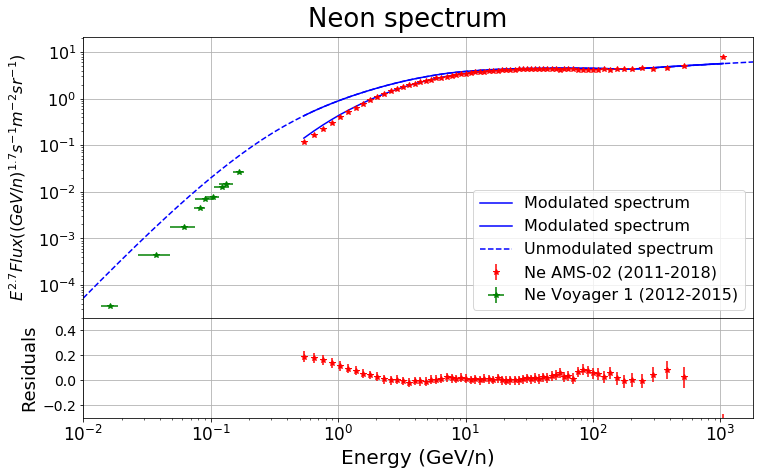

In [14]:
fig1, (frame1,frame2)=plt.subplots(2, sharex='col', figsize=(12,7), gridspec_kw=gs_kw)
fig1.suptitle("Neon spectrum", fontsize = 26, y=0.94)
    
fig1.subplots_adjust(hspace=0.)
frame1.set_yscale('log')
frame1.set_xscale('log', nonposx = 'clip')

frame1.errorbar(EmeanNe, fluxNe*np.power(EmeanNe, 2.7), yerr=errfluxNe**2.7, fmt= '*r', label = "Ne AMS-02 (2011-2018)") #Real data
frame1.errorbar(EmeanA, fluxA*np.power(EmeanA, 2.7), xerr=[Emean_min, Emean_max], yerr= errfluxA*np.power(EmeanA, 2.7), fmt= '*g', label = "Ne Voyager 1 (2012-2015)") #Real data
mod0 = np.interp(EmeanNe, E, np.array(table_Ne)[0]*(E**2.7))
frame1.plot(EmeanNe, mod0, "b-", label='Modulated spectrum')

mod0 = np.interp(EmeanNe, E, CR.modul(E, np.array(table_Ne)[0], myZ, 20, phi_ams))
frame1.plot(EmeanNe, mod0*(EmeanNe**2.7), "b-", label='Modulated spectrum')

mod1 = np.interp(E, E, (np.array(table_Ne))[0])
frame1.plot(E, mod1*(E**2.7), "b--", label='Unmodulated spectrum')

frame1.set_ylabel(r"$E^{2.7} Flux ((GeV/n)^{1.7} s^{-1} m^{-2} sr^{-1})$", fontsize = 16, labelpad = 10)
frame1.tick_params(axis = 'y', labelsize=16)
frame1.grid()
frame1.set_ylim(2*1e-5)
frame1.set_xlim(left = 0.001, right = 2000)
frame1.legend(fontsize = 16, loc = 4)

frame2.set_xscale("log")

diff = np.array(mod0-fluxNe)
frame2.errorbar(EmeanNe, diff/mod0, yerr = errfluxNe/fluxNe,  fmt= "r*")

mod1 = np.interp(EmeanA, E, mod1)
diff = np.array(mod1-fluxA)
frame2.errorbar(EmeanA, diff/mod1, yerr = errfluxA/fluxA, xerr = [Emean_min, Emean_max],  fmt= "g*")

frame2.set_ylabel("Residuals", fontsize = 18)
frame2.set_xlabel("Energy (GeV/n)", fontsize = 20)
frame2.set_xlim(left = 0.01, right = 1800)
frame2.grid()
plt.xticks(fontsize=17)
plt.yticks(fontsize=14)
frame2.set_ylim(bottom = -0.3, top = 0.5)
#frame2.legend(ncol = 4, loc = 0) #1 is upper right
plt.savefig('C:/Users/pedro/OneDrive/Escritorio/Ne_spectrum.png')
plt.savefig('C:/Users/pedro/OneDrive/Escritorio/Ne_spectrum.pdf')
plt.show()
plt.close()

# MAGNESIUM data

In [15]:
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/nuclei2/Mg_AMS_PRL_rig.txt' 
RmeanMg, RmeanMg_low, RmeanMg_up = np.loadtxt(data,skiprows=0,usecols=(0, 1, 2), unpack=True)
fluxMg1, fluxMg1_low, fluxMg1_up = np.loadtxt(data,skiprows=0,usecols=(3, 4, 5), unpack=True)
fluxMg = fluxMg1*(RmeanMg**-2.7)
fluxMg_low = fluxMg1_low*(RmeanMg**-2.7)
fluxMg_up =  fluxMg1_up*(RmeanMg**-2.7)

errfluxMg1 = (fluxMg_low + fluxMg_up)/2

EmeanMg, fluxMg, errfluxMg = CR.Rig_to_En(RmeanMg, 24, 12, fluxMg, errfluxMg1)

myZ = 12
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/BC/apjaa2409t9_ascii.txt' 
Z, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)
fluxA, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)
EmeanA = (1e-3*(0.5*(Emean_min + Emean_max)))[Z == myZ]
errfluxA = np.sqrt(sys**2 + sig**2)[Z==myZ]
fluxA = 1e3*fluxA[Z==myZ]

Emean_min = (1e-3 * Emean_min[Z==myZ])
Emean_max = (1e-3 * Emean_max[Z==myZ])

Emean_min = EmeanA - Emean_min
Emean_max = Emean_max - EmeanA

EmeanA = EmeanA

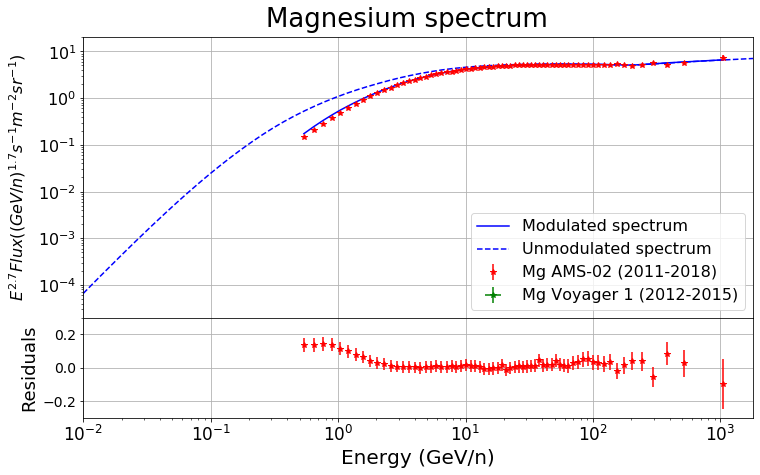

In [16]:
fig1, (frame1,frame2)=plt.subplots(2, sharex='col', figsize=(12,7), gridspec_kw=gs_kw)
fig1.suptitle("Magnesium spectrum", fontsize = 26, y=0.94)
    
fig1.subplots_adjust(hspace=0.)
frame1.set_yscale('log')
frame1.set_xscale('log', nonposx = 'clip')

frame1.errorbar(EmeanMg, fluxMg*np.power(EmeanMg, 2.7), yerr=errfluxMg*(EmeanMg**2.7), fmt= '*r', label = "Mg AMS-02 (2011-2018)") #Real data
frame1.errorbar(EmeanA, fluxA*np.power(EmeanA, 2.7), xerr=[Emean_min, Emean_max], yerr= errfluxA*np.power(EmeanA, 2.7), fmt= '*g', label = "Mg Voyager 1 (2012-2015)") #Real data
mod0 = np.interp(EmeanMg, E, CR.modul(E, np.array(table_Mg)[0], myZ, 24, phi_ams))
frame1.plot(EmeanMg, mod0*(EmeanMg**2.7), "b-", label='Modulated spectrum')

mod1 = np.interp(E, E, (np.array(table_Mg))[0])
frame1.plot(E, mod1*(E**2.7), "b--", label='Unmodulated spectrum')

frame1.set_ylabel(r"$E^{2.7} Flux ((GeV/n)^{1.7} s^{-1} m^{-2} sr^{-1})$", fontsize = 16, labelpad = 10)
frame1.tick_params(axis = 'y', labelsize=16)
frame1.grid()
frame1.set_ylim(2*1e-5)
frame1.set_xlim(left = 0.001, right = 2000)
frame1.legend(fontsize =16, loc=4)

frame2.set_xscale("log")

diff = np.array(mod0-fluxMg)
frame2.errorbar(EmeanMg, diff/mod0, yerr = errfluxMg/fluxMg,  fmt= "r*")

frame2.set_ylabel("Residuals", fontsize = 18)
frame2.set_xlabel("Energy (GeV/n)", fontsize = 20)
frame2.set_xlim(left = 0.01, right = 1800)
frame2.grid()
plt.xticks(fontsize=17)
plt.yticks(fontsize=14)
frame2.set_ylim(bottom = -0.3, top = 0.3)
#frame2.legend(ncol = 4, loc = 0) #1 is upper right
plt.savefig('C:/Users/pedro/OneDrive/Escritorio/Mg_spectrum.png')
plt.savefig('C:/Users/pedro/OneDrive/Escritorio/Mg_spectrum.pdf')
plt.show()
plt.close()

# SILICON data

In [17]:
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/nuclei2/Si_AMS_PRL_rig.txt' 
RmeanSi, RmeanSi_low, RmeanSi_up = np.loadtxt(data,skiprows=0,usecols=(0, 1, 2), unpack=True)
fluxSi1, fluxSi1_low, fluxSi1_up = np.loadtxt(data,skiprows=0,usecols=(3, 4, 5), unpack=True)
fluxSi = fluxSi1*(RmeanSi**-2.7)
fluxSi_low = fluxSi1_low*(RmeanSi**-2.7)
fluxSi_up =  fluxSi1_up*(RmeanSi**-2.7)

errfluxSi1 = (fluxSi_low + fluxSi_up)/2

EmeanSi, fluxSi, errfluxSi = CR.Rig_to_En(RmeanSi, 28, 14, fluxSi, errfluxSi1)

myZ = 14
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/BC/apjaa2409t9_ascii.txt' 
Z, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)
fluxA, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)
EmeanA = (1e-3*(0.5*(Emean_min + Emean_max)))[Z == myZ]
errfluxA = np.sqrt(sys**2 + sig**2)[Z==myZ]
fluxA = 1e3*fluxA[Z==myZ]

Emean_min = (1e-3 * Emean_min[Z==myZ])
Emean_max = (1e-3 * Emean_max[Z==myZ])

Emean_min = EmeanA - Emean_min
Emean_max = Emean_max - EmeanA

EmeanA = EmeanA

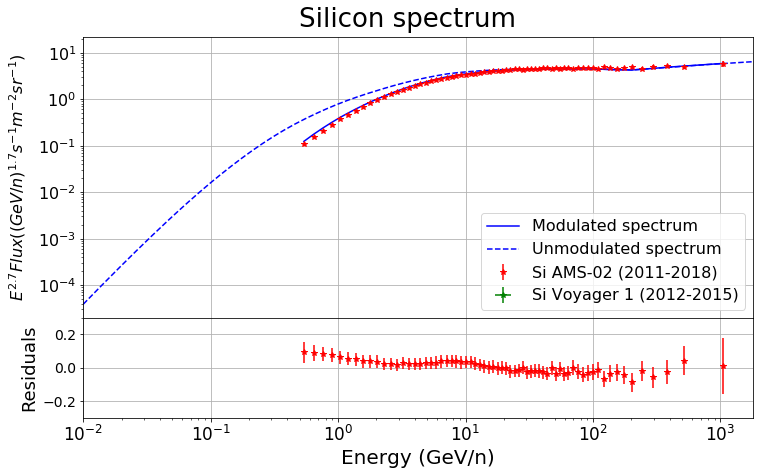

In [18]:
fig1, (frame1,frame2)=plt.subplots(2, sharex='col', figsize=(12,7), gridspec_kw=gs_kw)
fig1.suptitle("Silicon spectrum", fontsize = 26, y=0.94)
    
fig1.subplots_adjust(hspace=0.)
frame1.set_yscale('log')
frame1.set_xscale('log', nonposx = 'clip')

frame1.errorbar(EmeanSi, fluxSi*np.power(EmeanSi, 2.7), yerr=errfluxSi*(EmeanSi**2.7), fmt= '*r', label = "Si AMS-02 (2011-2018)") #Real data
frame1.errorbar(EmeanA, fluxA*np.power(EmeanA, 2.7), xerr=[Emean_min, Emean_max], yerr= errfluxA*np.power(EmeanA, 2.7), fmt= '*g', label = "Si Voyager 1 (2012-2015)") #Real data
mod0 = np.interp(EmeanSi, E, CR.modul(E, np.array(table_Si)[0], myZ, 28, phi_ams))
frame1.plot(EmeanSi, mod0*(EmeanSi**2.7), "b-", label='Modulated spectrum')

mod1 = np.interp(E, E, (np.array(table_Si))[0])
frame1.plot(E, mod1*(E**2.7), "b--", label='Unmodulated spectrum')

frame1.set_ylabel(r"$E^{2.7} Flux ((GeV/n)^{1.7} s^{-1} m^{-2} sr^{-1})$", fontsize = 16, labelpad = 10)
frame1.tick_params(axis = 'y', labelsize=16)
frame1.grid()
frame1.set_ylim(2*1e-5)
frame1.set_xlim(left = 0.001, right = 2000)
frame1.legend(fontsize =16, loc=4)

frame2.set_xscale("log")

diff = np.array(mod0-fluxSi)
frame2.errorbar(EmeanSi, 0.65*diff/mod0, yerr = errfluxSi/fluxSi,  fmt= "r*")

frame2.set_ylabel("Residuals", fontsize = 18)
frame2.set_xlabel("Energy (GeV/n)", fontsize = 20)
frame2.set_xlim(left = 0.01, right = 1800)
frame2.grid()
plt.xticks(fontsize=17)
plt.yticks(fontsize=14)
frame2.set_ylim(bottom = -0.3, top = 0.3)
#frame2.legend(ncol = 4, loc = 0) #1 is upper right
plt.savefig('C:/Users/pedro/OneDrive/Escritorio/Si_spectrum.png')
plt.savefig('C:/Users/pedro/OneDrive/Escritorio/Si_spectrum.pdf')
plt.show()
plt.close()

# SECONDARY-TO-PRIMARY RATIOS

# B/C PLOT

In [19]:
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/BC/B_C_ratio_AMS_PRL2018.txt'
EmeanBC = np.loadtxt(data,skiprows=0,usecols=(0,))
fluxBC, fluxBC_low, fluxBC_up = np.loadtxt(data,skiprows=0,usecols=(3,4, 5), unpack=True)
errfluxBC = (fluxBC_low + fluxBC_up)/2


MyZ = 6
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/BC/apjaa2409t9_ascii.txt' 
Z, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)
fluxA2, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)
EmeanA2 = (1e-3*(0.5*(Emean_min + Emean_max)))[Z ==MyZ]

errfluxA2 = (np.sqrt(sys**2 + sig**2))[Z==MyZ]
fluxA2 = 1e3*fluxA2[Z==MyZ]

errfluxA2 = (errfluxA2[EmeanA2 > 0.01])
fluxA2 = fluxA2[EmeanA2>0.01]

Emean_min = (1e-3 * Emean_min[Z==MyZ])[EmeanA2>0.01]
Emean_max = (1e-3 * Emean_max[Z==MyZ])[EmeanA2>0.01]

Emean_minA2 = EmeanA2[EmeanA2>0.01] - Emean_min
Emean_maxA2 = Emean_max - EmeanA2[EmeanA2>0.01] 

EmeanA2 = EmeanA2[EmeanA2>0.01]


MyZ = 5
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/BC/apjaa2409t9_ascii.txt' # ϕ=564 ± 26 MV
Z, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)
fluxA, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)
EmeanA = (1e-3*(0.5*(Emean_min + Emean_max)))[Z==MyZ]
errfluxA = 1e3*np.sqrt(sys**2 + sig**2)[Z==MyZ]
fluxA = 1e3*fluxA[Z==MyZ]

errfluxA = (errfluxA[EmeanA > 0.01])
fluxA = fluxA[EmeanA>0.01]
Emean_min = (1e-3 * Emean_min[Z==MyZ])[EmeanA>0.01]
Emean_max = (1e-3 * Emean_max[Z==MyZ])[EmeanA>0.01]

Emean_min = EmeanA[EmeanA>0.01] - Emean_min
Emean_max = Emean_max - EmeanA[EmeanA>0.01] 

EmeanA = EmeanA[EmeanA>0.01]
Etot = np.sort(list(EmeanBC)+ list(EmeanA))

fluxA2_new = np.interp(EmeanA, EmeanA2, fluxA2)
errfluxA2_new = np.interp(EmeanA, EmeanA2, errfluxA2)
EnerrA2 = 0.5*(Emean_minA2 + Emean_maxA2)
errEnA2_new = np.interp(EmeanA, EmeanA2, EnerrA2)

fluxerr = voyerr(fluxA, fluxA2_new, errfluxA, errfluxA2_new)
EnerrA = 0.5*(Emean_min + Emean_max)
Enerr = voyerr(fluxA, fluxA2_new, EnerrA, errEnA2_new)




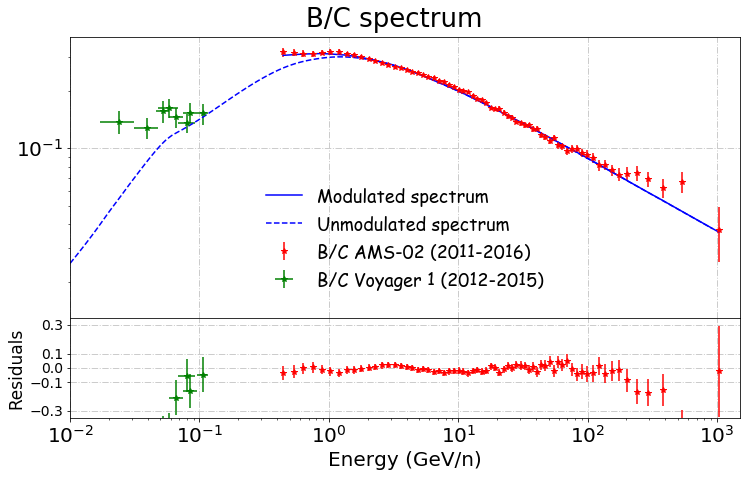

In [20]:
#B/C PLOT

fig1, (frame1,frame2)=plt.subplots(2, sharex='col', figsize=(12,7), gridspec_kw=gs_kw)
fig1.suptitle("B/C spectrum", fontsize = 26, y=0.94)
    
fig1.subplots_adjust(hspace=0.)
frame1.set_yscale('log')
frame1.set_xscale('log', nonposx = 'clip')

frame1.errorbar(EmeanBC, fluxBC, yerr = [fluxBC_low, fluxBC_up], fmt='*r', label = "B/C AMS-02 (2011-2016)") #Real data

frame1.errorbar(EmeanA, (fluxA/fluxA2_new), xerr= [Emean_min, Emean_max], yerr=fluxerr, fmt= '*g', label = "B/C Voyager 1 (2012-2015)") #Real data

B10 = np.interp(EmeanBC, E, CR.modul(E, np.array(table_B10)[0], 5, 10, phi_ams))
B11 = np.interp(EmeanBC, E, CR.modul(E, np.array(table_B11)[0], 5, 11, phi_ams))

C12 = np.interp(EmeanBC, E, CR.modul(E, np.array(table_C12)[0], 6, 12, phi_ams))
C13 = np.interp(EmeanBC, E, CR.modul(E, np.array(table_C13)[0], 6, 13, phi_ams))
C14 = np.interp(EmeanBC, E, CR.modul(E, np.array(table_C14)[0], 6, 14, phi_ams))

mod0 = (B10 + B11)/(C12 + C13 + C14)
frame1.plot(EmeanBC, mod0, "b-", label='Modulated spectrum')

mod1 = np.interp(E, E, (np.array(table_B10) + np.array(table_B11))[0]/(np.array(table_C12) + np.array(table_C13) + np.array(table_C14))[0])
frame1.plot(E[E<1e3], mod1[E<1e3], "b--", label='Unmodulated spectrum')

frame1.legend(prop={'family': 'fantasy', 'size': 18}, frameon = False, loc = 'lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1)

plt.ylabel("Flux ratio", fontsize = 20)
frame1.grid(color = '0.8', linestyle='-.', linewidth=1)
frame1.yaxis.set_tick_params(labelsize = 20)


diff = np.array(mod0-fluxBC)
frame2.errorbar(EmeanBC, diff/mod0, yerr = errfluxBC/fluxBC,  fmt= "r*")

mod1 = np.interp(EmeanA, E, mod1)
diff = np.array(mod1-(fluxA/fluxA2_new))
frame2.errorbar(EmeanA, diff/mod1, yerr = fluxerr/(fluxA/fluxA2_new), xerr = [Emean_min, Emean_max],  fmt= "g*")

frame1.set_ylim(bottom = 1.3e-2)
frame2.set_ylim(top = 0.35, bottom = -0.35)
frame2.set_xlim(right = 1.5e3, left = 0.01)
frame2.set_yticks([-0.3, -0.1, 0, 0.1, 0.3])

frame2.yaxis.set_tick_params(labelsize = 14)
frame2.xaxis.set_tick_params(labelsize = 20)

plt.ylabel("Residuals", fontsize = 17)
plt.xlabel("Energy (GeV/n)", fontsize = 20)
frame2.grid(color = '0.8', linestyle='-.', linewidth=1)
plt.savefig('C:/Users/pedro/OneDrive/Escritorio/BC.png')
plt.savefig('C:/Users/pedro/OneDrive/Escritorio/BC.pdf')
plt.show()
plt.close()

# B/O plot

In [21]:
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/BC/B_O_ratio_AMS_PRL2018.txt'
EmeanBO = np.loadtxt(data,skiprows=0,usecols=(0,))
fluxBO, fluxBO_low, fluxBO_up = np.loadtxt(data,skiprows=0,usecols=(3,4, 5), unpack=True)
errfluxBO = (fluxBO_low + fluxBO_up)/2


MyZ = 8
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/BC/apjaa2409t9_ascii.txt' 
Z, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)
fluxA2, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)
EmeanA2 = (1e-3*(0.5*(Emean_min + Emean_max)))[Z ==MyZ]

errfluxA2 = (np.sqrt(sys**2 + sig**2))[Z==MyZ]
fluxA2 = 1e3*fluxA2[Z==MyZ]

errfluxA2 = (errfluxA2[EmeanA2 > 0.01])
fluxA2 = fluxA2[EmeanA2>0.01]

Emean_min = (1e-3 * Emean_min[Z==MyZ])[EmeanA2>0.01]
Emean_max = (1e-3 * Emean_max[Z==MyZ])[EmeanA2>0.01]

Emean_minA2 = EmeanA2[EmeanA2>0.01] - Emean_min
Emean_maxA2 = Emean_max - EmeanA2[EmeanA2>0.01] 

EmeanA2 = EmeanA2[EmeanA2>0.01]


MyZ = 5
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/BC/apjaa2409t9_ascii.txt' # ϕ=564 ± 26 MV
Z, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)
fluxA, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)
EmeanA = (1e-3*(0.5*(Emean_min + Emean_max)))[Z==MyZ]
errfluxA = 1e3*np.sqrt(sys**2 + sig**2)[Z==MyZ]
fluxA = 1e3*fluxA[Z==MyZ]

errfluxA = (errfluxA[EmeanA > 0.01])
fluxA = fluxA[EmeanA>0.01]
Emean_min = (1e-3 * Emean_min[Z==MyZ])[EmeanA>0.01]
Emean_max = (1e-3 * Emean_max[Z==MyZ])[EmeanA>0.01]

Emean_min = EmeanA[EmeanA>0.01] - Emean_min
Emean_max = Emean_max - EmeanA[EmeanA>0.01] 

EmeanA = EmeanA[EmeanA>0.01]
Etot = np.sort(list(EmeanBO)+ list(EmeanA))

fluxA2_new = np.interp(EmeanA, EmeanA2, fluxA2)
errfluxA2_new = np.interp(EmeanA, EmeanA2, errfluxA2)
EnerrA2 = 0.5*(Emean_minA2 + Emean_maxA2)
errEnA2_new = np.interp(EmeanA, EmeanA2, EnerrA2)

fluxerr = voyerr(fluxA, fluxA2_new, errfluxA, errfluxA2_new)
EnerrA = 0.5*(Emean_min + Emean_max)
Enerr = voyerr(fluxA, fluxA2_new, EnerrA, errEnA2_new)

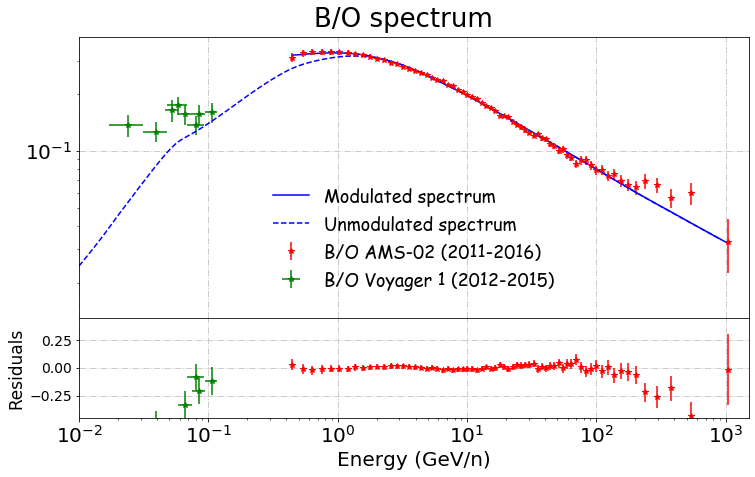

In [22]:
#B/O PLOT
fig1, (frame1,frame2)=plt.subplots(2, sharex='col', figsize=(12,7), gridspec_kw=gs_kw)
fig1.suptitle("B/O spectrum", fontsize = 26, y=0.94)
    
fig1.subplots_adjust(hspace=0.)
frame1.set_yscale('log')
frame1.set_xscale('log', nonposx = 'clip')

frame1.errorbar(EmeanBO, fluxBO, yerr = [fluxBO_low, fluxBO_up], fmt='*r', label = "B/O AMS-02 (2011-2016)") #Real data

frame1.errorbar(EmeanA, (fluxA/fluxA2_new), xerr = [Emean_min, Emean_max], yerr=fluxerr, fmt= '*g', label = "B/O Voyager 1 (2012-2015)") #Real data

B10 = np.interp(EmeanBO, E, CR.modul(E, np.array(table_B10)[0], 5, 10, phi_ams))
B11 = np.interp(EmeanBO, E, CR.modul(E, np.array(table_B11)[0], 5, 11, phi_ams))

O16 = np.interp(EmeanBO, E, CR.modul(E, np.array(table_O16)[0], 8, 16, phi_ams))
O17 = np.interp(EmeanBO, E, CR.modul(E, np.array(table_O17)[0], 8, 17, phi_ams))
O18 = np.interp(EmeanBO, E, CR.modul(E, np.array(table_O18)[0], 8, 18, phi_ams))

mod0 = (B10 + B11)/(O16 + O17 + O18)
frame1.plot(EmeanBO, mod0, "b-", label='Modulated spectrum')

mod1 = np.interp(E, E, (np.array(table_B10) + np.array(table_B11))[0]/(np.array(table_O16) + np.array(table_O17) + np.array(table_O18))
[0])
frame1.plot(E[E<1e3], mod1[E<1e3], "b--", label='Unmodulated spectrum')

frame1.legend(prop={'family': 'fantasy', 'size': 18}, frameon = False, loc = 'lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1)

plt.ylabel("Flux ratio", fontsize = 20)
frame1.grid(color = '0.8', linestyle='-.', linewidth=1)
frame1.yaxis.set_tick_params(labelsize = 20)


diff = np.array(mod0-fluxBO)
frame2.errorbar(EmeanBO, diff/mod0, yerr = errfluxBO/fluxBO,  fmt= "r*")

mod1 = np.interp(EmeanA, E, mod1)
diff = np.array(mod1-(fluxA/fluxA2_new))
frame2.errorbar(EmeanA, diff/mod1, yerr = fluxerr/(fluxA/fluxA2_new), xerr = [Emean_min, Emean_max],  fmt= "g*")

frame1.set_ylim(bottom = 1.3e-2)
frame2.set_ylim(top = 0.45, bottom = -0.45)
frame2.set_xlim(right = 1.5e3, left = 0.01)

frame2.yaxis.set_tick_params(labelsize = 14)
frame2.xaxis.set_tick_params(labelsize = 20)

plt.ylabel("Residuals", fontsize = 17)
plt.xlabel("Energy (GeV/n)", fontsize = 20)
frame2.grid(color = '0.8', linestyle='-.', linewidth=1)
plt.savefig('C:/Users/pedro/OneDrive/Escritorio/BO_constant.png')
plt.savefig('C:/Users/pedro/OneDrive/Escritorio/BO_constant.pdf')
plt.show()
plt.close()

# Be/C

In [23]:
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/nuclei1/Be_C_ratio_AMS_PRL2018.txt'
EmeanBeC = np.loadtxt(data,skiprows=0,usecols=(0,))
fluxBeC, fluxBeC_low, fluxBeC_up = np.loadtxt(data,skiprows=0,usecols=(3,4, 5), unpack=True)
errfluxBeC = (fluxBeC_low + fluxBeC_up)/2


MyZ = 6
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/BC/apjaa2409t9_ascii.txt' 
Z, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)
fluxA2, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)
EmeanA2 = (1e-3*(0.5*(Emean_min + Emean_max)))[Z ==MyZ]

errfluxA2 = (np.sqrt(sys**2 + sig**2))[Z==MyZ]
fluxA2 = 1e3*fluxA2[Z==MyZ]

errfluxA2 = (errfluxA2[EmeanA2 > 0.01])
fluxA2 = fluxA2[EmeanA2>0.01]

Emean_min = (1e-3 * Emean_min[Z==MyZ])[EmeanA2>0.01]
Emean_max = (1e-3 * Emean_max[Z==MyZ])[EmeanA2>0.01]

Emean_minA2 = EmeanA2[EmeanA2>0.01] - Emean_min
Emean_maxA2 = Emean_max - EmeanA2[EmeanA2>0.01] 

EmeanA2 = EmeanA2[EmeanA2>0.01]


MyZ = 4
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/BC/apjaa2409t9_ascii.txt' # ϕ=564 ± 26 MV
Z, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)
fluxA, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)
EmeanA = (1e-3*(0.5*(Emean_min + Emean_max)))[Z==MyZ]
errfluxA = 1e3*np.sqrt(sys**2 + sig**2)[Z==MyZ]
fluxA = 1e3*fluxA[Z==MyZ]

errfluxA = (errfluxA[EmeanA > 0.01])
fluxA = fluxA[EmeanA>0.01]
Emean_min = (1e-3 * Emean_min[Z==MyZ])[EmeanA>0.01]
Emean_max = (1e-3 * Emean_max[Z==MyZ])[EmeanA>0.01]

Emean_min = EmeanA[EmeanA>0.01] - Emean_min
Emean_max = Emean_max - EmeanA[EmeanA>0.01] 

EmeanA = EmeanA[EmeanA>0.01]
Etot = np.sort(list(EmeanBeC)+ list(EmeanA))

fluxA2_new = np.interp(EmeanA, EmeanA2, fluxA2)
errfluxA2_new = np.interp(EmeanA, EmeanA2, errfluxA2)
EnerrA2 = 0.5*(Emean_minA2 + Emean_maxA2)
errEnA2_new = np.interp(EmeanA, EmeanA2, EnerrA2)

fluxerr = voyerr(fluxA, fluxA2_new, errfluxA, errfluxA2_new)
EnerrA = 0.5*(Emean_min + Emean_max)
Enerr = voyerr(fluxA, fluxA2_new, EnerrA, errEnA2_new)

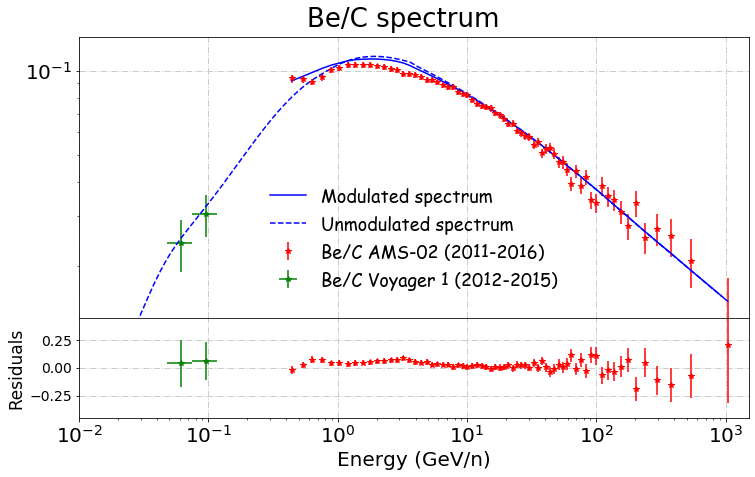

In [24]:
#Be/C PLOT
fig1, (frame1,frame2)=plt.subplots(2, sharex='col', figsize=(12,7), gridspec_kw=gs_kw)
fig1.suptitle("Be/C spectrum", fontsize = 26, y=0.94)
    
fig1.subplots_adjust(hspace=0.)
frame1.set_yscale('log')
frame1.set_xscale('log', nonposx = 'clip')

frame1.errorbar(EmeanBeC, fluxBeC, yerr = [fluxBeC_low, fluxBeC_up], fmt='*r', label = "Be/C AMS-02 (2011-2016)") #Real data

frame1.errorbar(EmeanA, (fluxA/fluxA2_new), xerr = [Emean_min, Emean_max], yerr=fluxerr, fmt= '*g', label = "Be/C Voyager 1 (2012-2015)") #Real data

Be7 = np.interp(EmeanBeC, E, CR.modul(E, np.array(table_Be7)[0], 4, 7, phi_ams))
Be9 = np.interp(EmeanBeC, E, CR.modul(E, np.array(table_Be9)[0], 4, 9, phi_ams))
Be10 = np.interp(EmeanBeC, E, CR.modul(E, np.array(table_Be10)[0], 4, 10, phi_ams))

C12 = np.interp(EmeanBeC, E, CR.modul(E, np.array(table_C12)[0], 6, 12, phi_ams))
C13 = np.interp(EmeanBeC, E, CR.modul(E, np.array(table_C13)[0], 6, 13, phi_ams))
C14 = np.interp(EmeanBeC, E, CR.modul(E, np.array(table_C14)[0], 6, 14, phi_ams))

mod0 = (Be7 + Be9 + Be10)/(C12 + C13 + C14)
frame1.plot(EmeanBeC, mod0, "b-", label='Modulated spectrum')

mod1 = np.interp(E, E, (np.array(table_Be10) + np.array(table_Be9) + np.array(table_Be7))[0]/(np.array(table_C12) + np.array(table_C13) + np.array(table_C14))[0])
frame1.plot(E[E<1e3], mod1[E<1e3], "b--", label='Unmodulated spectrum')

frame1.legend(prop={'family': 'fantasy', 'size': 18}, frameon = False, loc = 'lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1)

plt.ylabel("Flux ratio", fontsize = 20)
frame1.grid(color = '0.8', linestyle='-.', linewidth=1)
frame1.yaxis.set_tick_params(labelsize = 20)


diff = np.array(mod0-fluxBeC)
frame2.errorbar(EmeanBeC, diff/mod0, yerr = errfluxBeC/fluxBeC,  fmt= "r*")

mod1 = np.interp(EmeanA, E, mod1)
diff = np.array(mod1-(fluxA/fluxA2_new))
frame2.errorbar(EmeanA, diff/mod1, yerr = fluxerr/(fluxA/fluxA2_new), xerr = [Emean_min, Emean_max],  fmt= "g*")

frame1.set_ylim(bottom = 1.3e-2)
frame2.set_ylim(top = 0.45, bottom = -0.45)
frame2.set_xlim(right = 1.5e3, left = 0.01)

frame2.yaxis.set_tick_params(labelsize = 14)
frame2.xaxis.set_tick_params(labelsize = 20)

plt.ylabel("Residuals", fontsize = 17)
plt.xlabel("Energy (GeV/n)", fontsize = 20)
frame2.grid(color = '0.8', linestyle='-.', linewidth=1)
plt.savefig('C:/Users/pedro/OneDrive/Escritorio/BeC_constant.png')
plt.savefig('C:/Users/pedro/OneDrive/Escritorio/BeC_constant.pdf')
plt.show()
plt.close()

# Be/O

In [25]:
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/nuclei1/Be_AMS_PRL2018.txt' # ϕ=564 ± 26 MV
EmeanBe, EmeanBe_low, EmeanBe_up = np.loadtxt(data,skiprows=0,usecols=(0, 1, 2), unpack=True)
fluxBe, fluxBe_low, fluxBe_up = np.loadtxt(data,skiprows=0,usecols=(3, 4, 5), unpack=True)
errfluxBe = (fluxBe_low + fluxBe_up)/2

data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/nuclei1/O_AMS_PRL2017.txt' # ϕ=564 ± 26 MV
EmeanO, EmeanO_low, EmeanO_up = np.loadtxt(data,skiprows=0,usecols=(0, 1, 2), unpack=True)
fluxO, fluxO_low, fluxO_up = np.loadtxt(data,skiprows=0,usecols=(3, 4, 5), unpack=True)
errfluxO = (fluxO_low + fluxO_up)/2

fluxO = np.interp(EmeanBe, EmeanO, fluxO)
errfluxO = np.interp(EmeanBe, EmeanO, errfluxO)
fluxBeO = fluxBe/fluxO
errfluxBeO = np.sqrt((errfluxBe/fluxO)**2 + (errfluxO * (fluxBe/(fluxO)**2))**2)
EmeanBeO = EmeanBe


MyZ = 8
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/BC/apjaa2409t9_ascii.txt' 
Z, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)
fluxA2, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)
EmeanA2 = (1e-3*(0.5*(Emean_min + Emean_max)))[Z ==MyZ]

errfluxA2 = (np.sqrt(sys**2 + sig**2))[Z==MyZ]
fluxA2 = 1e3*fluxA2[Z==MyZ]

errfluxA2 = (errfluxA2[EmeanA2 > 0.01])
fluxA2 = fluxA2[EmeanA2>0.01]

Emean_min = (1e-3 * Emean_min[Z==MyZ])[EmeanA2>0.01]
Emean_max = (1e-3 * Emean_max[Z==MyZ])[EmeanA2>0.01]

Emean_minA2 = EmeanA2[EmeanA2>0.01] - Emean_min
Emean_maxA2 = Emean_max - EmeanA2[EmeanA2>0.01] 

EmeanA2 = EmeanA2[EmeanA2>0.01]


MyZ = 4
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/BC/apjaa2409t9_ascii.txt' # ϕ=564 ± 26 MV
Z, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)
fluxA, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)
EmeanA = (1e-3*(0.5*(Emean_min + Emean_max)))[Z==MyZ]
errfluxA = 1e3*np.sqrt(sys**2 + sig**2)[Z==MyZ]
fluxA = 1e3*fluxA[Z==MyZ]

errfluxA = (errfluxA[EmeanA > 0.01])
fluxA = fluxA[EmeanA>0.01]
Emean_min = (1e-3 * Emean_min[Z==MyZ])[EmeanA>0.01]
Emean_max = (1e-3 * Emean_max[Z==MyZ])[EmeanA>0.01]

Emean_min = EmeanA[EmeanA>0.01] - Emean_min
Emean_max = Emean_max - EmeanA[EmeanA>0.01] 

EmeanA = EmeanA[EmeanA>0.01]
Etot = np.sort(list(EmeanBeO)+ list(EmeanA))

fluxA2_new = np.interp(EmeanA, EmeanA2, fluxA2)
errfluxA2_new = np.interp(EmeanA, EmeanA2, errfluxA2)
EnerrA2 = 0.5*(Emean_minA2 + Emean_maxA2)
errEnA2_new = np.interp(EmeanA, EmeanA2, EnerrA2)

fluxerr = voyerr(fluxA, fluxA2_new, errfluxA, errfluxA2_new)
EnerrA = 0.5*(Emean_min + Emean_max)
Enerr = voyerr(fluxA, fluxA2_new, EnerrA, errEnA2_new)

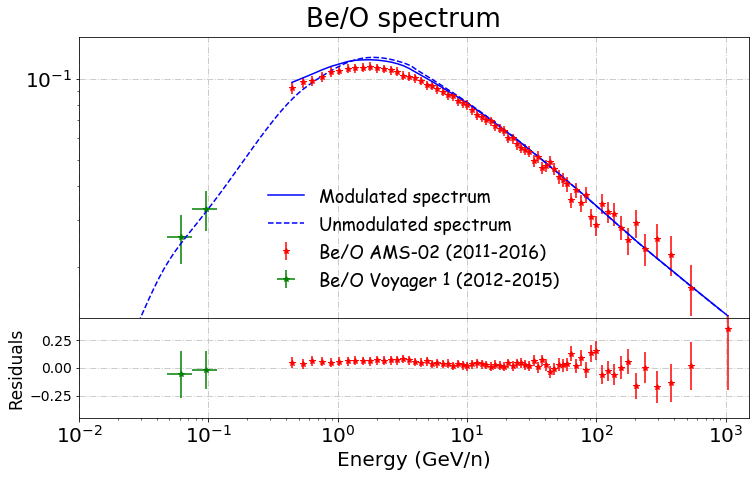

In [26]:
#Be/O PLOT
fig1, (frame1,frame2)=plt.subplots(2, sharex='col', figsize=(12,7), gridspec_kw=gs_kw)
fig1.suptitle("Be/O spectrum", fontsize = 26, y=0.94)
    
fig1.subplots_adjust(hspace=0.)
frame1.set_yscale('log')
frame1.set_xscale('log', nonposx = 'clip')

frame1.errorbar(EmeanBeO, fluxBeO, yerr = errfluxBeO, fmt='*r', label = "Be/O AMS-02 (2011-2016)") #Real data

frame1.errorbar(EmeanA, (fluxA/fluxA2_new), xerr = [Emean_min, Emean_max], yerr=fluxerr, fmt= '*g', label = "Be/O Voyager 1 (2012-2015)") #Real data

Be7 = np.interp(EmeanBeO, E, CR.modul(E, np.array(table_Be7)[0], 4, 7, phi_ams))
Be9 = np.interp(EmeanBeO, E, CR.modul(E, np.array(table_Be9)[0], 4, 9, phi_ams))
Be10 = np.interp(EmeanBeO, E, CR.modul(E, np.array(table_Be10)[0], 4, 10, phi_ams))

O16 = np.interp(EmeanBeO, E, CR.modul(E, np.array(table_O16)[0], 8, 16, phi_ams))
O17 = np.interp(EmeanBeO, E, CR.modul(E, np.array(table_O17)[0], 8, 17, phi_ams))
O18 = np.interp(EmeanBeO, E, CR.modul(E, np.array(table_O18)[0], 8, 18, phi_ams))

mod0 = (Be7 + Be9 + Be10)/(O16 + O17 + O18)
frame1.plot(EmeanBeO, mod0, "b-", label='Modulated spectrum')

mod1 = np.interp(E, E, (np.array(table_Be10) + np.array(table_Be9) + np.array(table_Be7))[0]/(np.array(table_O16) + np.array(table_O17) + np.array(table_O18))[0])
frame1.plot(E[E<1e3], mod1[E<1e3], "b--", label='Unmodulated spectrum')

frame1.legend(prop={'family': 'fantasy', 'size': 18}, frameon = False, loc = 'lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1)

plt.ylabel("Flux ratio", fontsize = 20)
frame1.grid(color = '0.8', linestyle='-.', linewidth=1)
frame1.yaxis.set_tick_params(labelsize = 20)


diff = np.array(mod0-fluxBeO)
frame2.errorbar(EmeanBeO, diff/mod0, yerr = errfluxBeO/fluxBeO,  fmt= "r*")

mod1 = np.interp(EmeanA, E, mod1)
diff = np.array(mod1-(fluxA/fluxA2_new))
frame2.errorbar(EmeanA, diff/mod1, yerr = fluxerr/(fluxA/fluxA2_new), xerr = [Emean_min, Emean_max],  fmt= "g*")

frame1.set_ylim(bottom = 1.3e-2)
frame2.set_ylim(top = 0.45, bottom = -0.45)
frame2.set_xlim(right = 1.5e3, left = 0.01)

frame2.yaxis.set_tick_params(labelsize = 14)
frame2.xaxis.set_tick_params(labelsize = 20)

plt.ylabel("Residuals", fontsize = 17)
plt.xlabel("Energy (GeV/n)", fontsize = 20)
frame2.grid(color = '0.8', linestyle='-.', linewidth=1)
plt.savefig('C:/Users/pedro/OneDrive/Escritorio/BeO_constant.png')
plt.savefig('C:/Users/pedro/OneDrive/Escritorio/BeO_constant.pdf')
plt.show()
plt.close()

# Li/C

In [27]:
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/nuclei1/Li_C_ratio_AMS_PRL2018.txt'
EmeanLiC = np.loadtxt(data,skiprows=0,usecols=(0,))
fluxLiC, fluxLiC_low, fluxLiC_up = np.loadtxt(data,skiprows=0,usecols=(3,4, 5), unpack=True)
errfluxLiC = (fluxLiC_low + fluxLiC_up)/2


MyZ = 6
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/BC/apjaa2409t9_ascii.txt' 
Z, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)
fluxA2, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)
EmeanA2 = (1e-3*(0.5*(Emean_min + Emean_max)))[Z ==MyZ]

errfluxA2 = (np.sqrt(sys**2 + sig**2))[Z==MyZ]
fluxA2 = 1e3*fluxA2[Z==MyZ]

errfluxA2 = (errfluxA2[EmeanA2 > 0.01])
fluxA2 = fluxA2[EmeanA2>0.01]

Emean_min = (1e-3 * Emean_min[Z==MyZ])[EmeanA2>0.01]
Emean_max = (1e-3 * Emean_max[Z==MyZ])[EmeanA2>0.01]

Emean_minA2 = EmeanA2[EmeanA2>0.01] - Emean_min
Emean_maxA2 = Emean_max - EmeanA2[EmeanA2>0.01] 

EmeanA2 = EmeanA2[EmeanA2>0.01]


MyZ = 3
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/BC/apjaa2409t9_ascii.txt' # ϕ=564 ± 26 MV
Z, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)
fluxA, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)
EmeanA = (1e-3*(0.5*(Emean_min + Emean_max)))[Z==MyZ]
errfluxA = 1e3*np.sqrt(sys**2 + sig**2)[Z==MyZ]
fluxA = 1e3*fluxA[Z==MyZ]

errfluxA = (errfluxA[EmeanA > 0.01])
fluxA = fluxA[EmeanA>0.01]
Emean_min = (1e-3 * Emean_min[Z==MyZ])[EmeanA>0.01]
Emean_max = (1e-3 * Emean_max[Z==MyZ])[EmeanA>0.01]

Emean_min = EmeanA[EmeanA>0.01] - Emean_min
Emean_max = Emean_max - EmeanA[EmeanA>0.01] 

EmeanA = EmeanA[EmeanA>0.01]
Etot = np.sort(list(EmeanLiC)+ list(EmeanA))

fluxA2_new = np.interp(EmeanA, EmeanA2, fluxA2)
errfluxA2_new = np.interp(EmeanA, EmeanA2, errfluxA2)
EnerrA2 = 0.5*(Emean_minA2 + Emean_maxA2)
errEnA2_new = np.interp(EmeanA, EmeanA2, EnerrA2)

fluxerr = voyerr(fluxA, fluxA2_new, errfluxA, errfluxA2_new)
EnerrA = 0.5*(Emean_min + Emean_max)
Enerr = voyerr(fluxA, fluxA2_new, EnerrA, errEnA2_new)

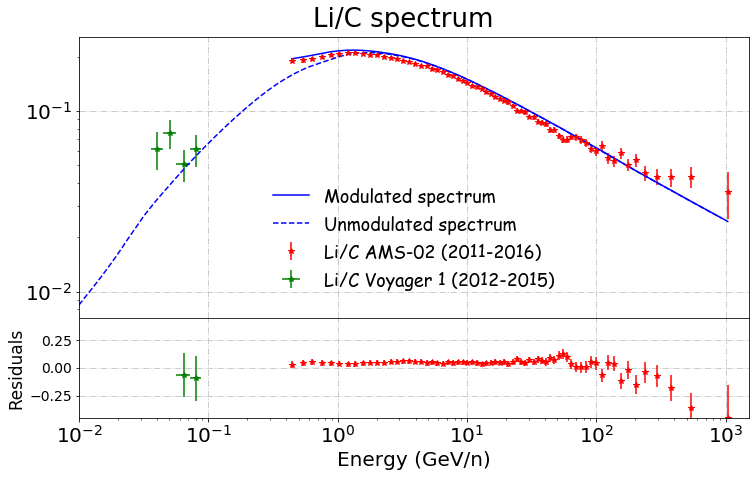

In [28]:
#Li/C PLOT

fig1, (frame1,frame2)=plt.subplots(2, sharex='col', figsize=(12,7), gridspec_kw=gs_kw)
fig1.suptitle("Li/C spectrum", fontsize = 26, y=0.94)
    
fig1.subplots_adjust(hspace=0.)
frame1.set_yscale('log')
frame1.set_xscale('log', nonposx = 'clip')

frame1.errorbar(EmeanLiC, fluxLiC, yerr = [fluxLiC_low, fluxLiC_up], fmt='*r', label = "Li/C AMS-02 (2011-2016)") #Real data

frame1.errorbar(EmeanA, (fluxA/fluxA2_new), xerr = [Emean_min, Emean_max], yerr=fluxerr, fmt= '*g', label = "Li/C Voyager 1 (2012-2015)") #Real data

Li6 = np.interp(EmeanLiC, E, CR.modul(E, np.array(table_Li6)[0], 3, 6, phi_ams))
Li7 = np.interp(EmeanLiC, E, CR.modul(E, np.array(table_Li7)[0], 3, 7, phi_ams))

C12 = np.interp(EmeanLiC, E, CR.modul(E, np.array(table_C12)[0], 6, 12, phi_ams))
C13 = np.interp(EmeanLiC, E, CR.modul(E, np.array(table_C13)[0], 6, 13, phi_ams))
C14 = np.interp(EmeanLiC, E, CR.modul(E, np.array(table_C14)[0], 6, 14, phi_ams))

mod0 = (Li6 + Li7)/(C12 + C13 + C14)
frame1.plot(EmeanLiC, mod0, "b-", label='Modulated spectrum')

mod1 = np.interp(E, E, (np.array(table_Li7) + np.array(table_Li6))[0]/(np.array(table_C12) + np.array(table_C13) + np.array(table_C14))[0])
frame1.plot(E[E<1e3], mod1[E<1e3], "b--", label='Unmodulated spectrum')

frame1.legend(prop={'family': 'fantasy', 'size': 18}, frameon = False, loc = 'lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1)

plt.ylabel("Flux ratio", fontsize = 20)
frame1.grid(color = '0.8', linestyle='-.', linewidth=1)
frame1.yaxis.set_tick_params(labelsize = 20)


diff = np.array(mod0-fluxLiC)
frame2.errorbar(EmeanLiC, diff/mod0, yerr = errfluxLiC/fluxLiC,  fmt= "r*")

mod1 = np.interp(EmeanA, E, mod1)
diff = np.array(mod1-(fluxA/fluxA2_new))
frame2.errorbar(EmeanA, diff/mod1, yerr = fluxerr/(fluxA/fluxA2_new), xerr = [Emean_min, Emean_max],  fmt= "g*")

#frame1.set_ylim(bottom = 1.3e-2)
frame2.set_ylim(top = 0.45, bottom = -0.45)
frame2.set_xlim(right = 1.5e3, left = 0.01)

frame2.yaxis.set_tick_params(labelsize = 14)
frame2.xaxis.set_tick_params(labelsize = 20)

plt.ylabel("Residuals", fontsize = 17)
plt.xlabel("Energy (GeV/n)", fontsize = 20)
frame2.grid(color = '0.8', linestyle='-.', linewidth=1)
plt.savefig('C:/Users/pedro/OneDrive/Escritorio/LiC.png')
plt.savefig('C:/Users/pedro/OneDrive/Escritorio/LiC.pdf')
plt.show()
plt.close()

# Li/O

In [29]:
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/nuclei1/Li_O_ratio_AMS_PRL2018.txt'
EmeanLiO = np.loadtxt(data,skiprows=0,usecols=(0,))
fluxLiO, fluxLiO_low, fluxLiO_up = np.loadtxt(data,skiprows=0,usecols=(3,4, 5), unpack=True)
errfluxLiO = (fluxLiO_low + fluxLiO_up)/2


MyZ = 8
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/BC/apjaa2409t9_ascii.txt' 
Z, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)
fluxA2, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)
EmeanA2 = (1e-3*(0.5*(Emean_min + Emean_max)))[Z ==MyZ]

errfluxA2 = (np.sqrt(sys**2 + sig**2))[Z==MyZ]
fluxA2 = 1e3*fluxA2[Z==MyZ]

errfluxA2 = (errfluxA2[EmeanA2 > 0.01])
fluxA2 = fluxA2[EmeanA2>0.01]

Emean_min = (1e-3 * Emean_min[Z==MyZ])[EmeanA2>0.01]
Emean_max = (1e-3 * Emean_max[Z==MyZ])[EmeanA2>0.01]

Emean_minA2 = EmeanA2[EmeanA2>0.01] - Emean_min
Emean_maxA2 = Emean_max - EmeanA2[EmeanA2>0.01] 

EmeanA2 = EmeanA2[EmeanA2>0.01]


MyZ = 3
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/BC/apjaa2409t9_ascii.txt' # ϕ=564 ± 26 MV
Z, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)
fluxA, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)
EmeanA = (1e-3*(0.5*(Emean_min + Emean_max)))[Z==MyZ]
errfluxA = 1e3*np.sqrt(sys**2 + sig**2)[Z==MyZ]
fluxA = 1e3*fluxA[Z==MyZ]

errfluxA = (errfluxA[EmeanA > 0.01])
fluxA = fluxA[EmeanA>0.01]
Emean_min = (1e-3 * Emean_min[Z==MyZ])[EmeanA>0.01]
Emean_max = (1e-3 * Emean_max[Z==MyZ])[EmeanA>0.01]

Emean_min = EmeanA[EmeanA>0.01] - Emean_min
Emean_max = Emean_max - EmeanA[EmeanA>0.01] 

EmeanA = EmeanA[EmeanA>0.01]
Etot = np.sort(list(EmeanLiO)+ list(EmeanA))

fluxA2_new = np.interp(EmeanA, EmeanA2, fluxA2)
errfluxA2_new = np.interp(EmeanA, EmeanA2, errfluxA2)
EnerrA2 = 0.5*(Emean_minA2 + Emean_maxA2)
errEnA2_new = np.interp(EmeanA, EmeanA2, EnerrA2)

fluxerr = voyerr(fluxA, fluxA2_new, errfluxA, errfluxA2_new)
EnerrA = 0.5*(Emean_min + Emean_max)
Enerr = voyerr(fluxA, fluxA2_new, EnerrA, errEnA2_new)

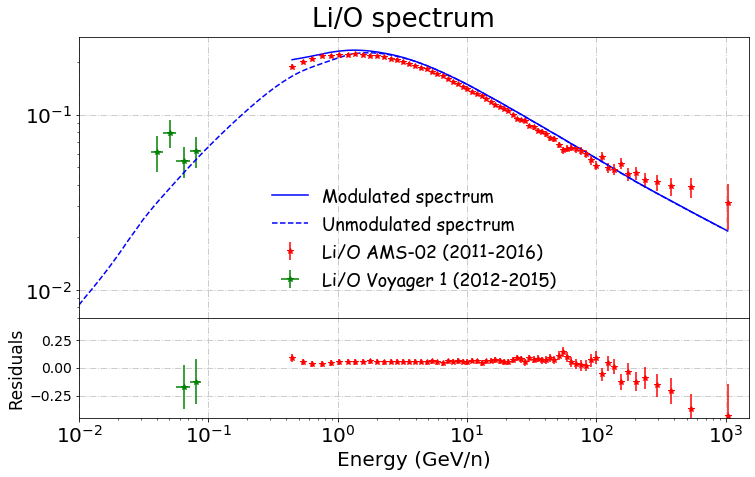

In [30]:
#Li/O PLOT

fig1, (frame1,frame2)=plt.subplots(2, sharex='col', figsize=(12,7), gridspec_kw=gs_kw)
fig1.suptitle("Li/O spectrum", fontsize = 26, y=0.94)
    
fig1.subplots_adjust(hspace=0.)
frame1.set_yscale('log')
frame1.set_xscale('log', nonposx = 'clip')

frame1.errorbar(EmeanLiO, fluxLiO, yerr = [fluxLiO_low, fluxLiO_up], fmt='*r', label = "Li/O AMS-02 (2011-2016)") #Real data

frame1.errorbar(EmeanA, (fluxA/fluxA2_new), xerr = [Emean_min, Emean_max], yerr=fluxerr, fmt= '*g', label = "Li/O Voyager 1 (2012-2015)") #Real data

Li6 = np.interp(EmeanLiO, E, CR.modul(E, np.array(table_Li6)[0], 3, 6, phi_ams))
Li7 = np.interp(EmeanLiO, E, CR.modul(E, np.array(table_Li7)[0], 3, 7, phi_ams))

O16 = np.interp(EmeanBeO, E, CR.modul(E, np.array(table_O16)[0], 8, 16, phi_ams))
O17 = np.interp(EmeanBeO, E, CR.modul(E, np.array(table_O17)[0], 8, 17, phi_ams))
O18 = np.interp(EmeanBeO, E, CR.modul(E, np.array(table_O18)[0], 8, 18, phi_ams))

mod0 = (Li6 + Li7)/(O16 + O17 + O18)
frame1.plot(EmeanLiO, mod0, "b-", label='Modulated spectrum')

mod1 = np.interp(E, E, (np.array(table_Li7) + np.array(table_Li6))[0]/(np.array(table_O16) + np.array(table_O17) + np.array(table_O18))[0])
frame1.plot(E[E<1e3], mod1[E<1e3], "b--", label='Unmodulated spectrum')

frame1.legend(prop={'family': 'fantasy', 'size': 18}, frameon = False, loc = 'lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1)

plt.ylabel("Flux ratio", fontsize = 20)
frame1.grid(color = '0.8', linestyle='-.', linewidth=1)
frame1.yaxis.set_tick_params(labelsize = 20)

diff = np.array(mod0-fluxLiO)
frame2.errorbar(EmeanLiO, diff/mod0, yerr = errfluxLiO/fluxLiO,  fmt= "r*")

mod1 = np.interp(EmeanA, E, mod1)
diff = np.array(mod1-(fluxA/fluxA2_new))
frame2.errorbar(EmeanA, diff/mod1, yerr = fluxerr/(fluxA/fluxA2_new), xerr = [Emean_min, Emean_max],  fmt= "g*")

#frame1.set_ylim(bottom = 1.3e-2)
frame2.set_ylim(top = 0.45, bottom = -0.45)
frame2.set_xlim(right = 1.5e3, left = 0.01)

frame2.yaxis.set_tick_params(labelsize = 14)
frame2.xaxis.set_tick_params(labelsize = 20)

plt.ylabel("Residuals", fontsize = 17)
plt.xlabel("Energy (GeV/n)", fontsize = 20)
frame2.grid(color = '0.8', linestyle='-.', linewidth=1)

plt.savefig('C:/Users/pedro/OneDrive/Escritorio/LiO.png')
plt.savefig('C:/Users/pedro/OneDrive/Escritorio/LiO.pdf')
plt.show()
plt.close()

# SECONDARY-TO-SECONDARY RATIOS

# Be/B

In [13]:
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/Be_B_ratio_AMS_PRL2018.txt'
EmeanBeB = np.loadtxt(data,skiprows=0,usecols=(0,))
fluxBeB, fluxBeB_low, fluxBeB_up = np.loadtxt(data,skiprows=0,usecols=(3, 4, 5), unpack=True)
errfluxBeB = (fluxBeB_low + fluxBeB_up)/2


MyZ = 5
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/BC/apjaa2409t9_ascii.txt' 
Z, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)
fluxA2, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)
EmeanA2 = (1e-3*(0.5*(Emean_min + Emean_max)))[Z ==MyZ]

errfluxA2 = (np.sqrt(sys**2 + sig**2))[Z==MyZ]
fluxA2 = 1e3*fluxA2[Z==MyZ]

errfluxA2 = (errfluxA2[EmeanA2 > 0.01])
fluxA2 = fluxA2[EmeanA2>0.01]

Emean_min = (1e-3 * Emean_min[Z==MyZ])[EmeanA2>0.01]
Emean_max = (1e-3 * Emean_max[Z==MyZ])[EmeanA2>0.01]

Emean_minA2 = EmeanA2[EmeanA2>0.01] - Emean_min
Emean_maxA2 = Emean_max - EmeanA2[EmeanA2>0.01] 

EmeanA2 = EmeanA2[EmeanA2>0.01]

MyZ = 4
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/BC/apjaa2409t9_ascii.txt' # ϕ=564 ± 26 MV
Z, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)
fluxA, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)
EmeanA = (1e-3*(0.5*(Emean_min + Emean_max)))[Z==MyZ]
errfluxA = 1e3*np.sqrt(sys**2 + sig**2)[Z==MyZ]
fluxA = 1e3*fluxA[Z==MyZ]

errfluxA = (errfluxA[EmeanA > 0.01])
fluxA = fluxA[EmeanA>0.01]
Emean_min = (1e-3 * Emean_min[Z==MyZ])[EmeanA>0.01]
Emean_max = (1e-3 * Emean_max[Z==MyZ])[EmeanA>0.01]

Emean_min = EmeanA[EmeanA>0.01] - Emean_min
Emean_max = Emean_max - EmeanA[EmeanA>0.01] 

EmeanA = EmeanA[EmeanA>0.01]
Etot = np.sort(list(EmeanBeB)+ list(EmeanA))

fluxA2_new = np.interp(EmeanA, EmeanA2, fluxA2)
errfluxA2_new = np.interp(EmeanA, EmeanA2, errfluxA2)

fluxerr = voyerr(fluxA, fluxA2_new, errfluxA, errfluxA2_new)

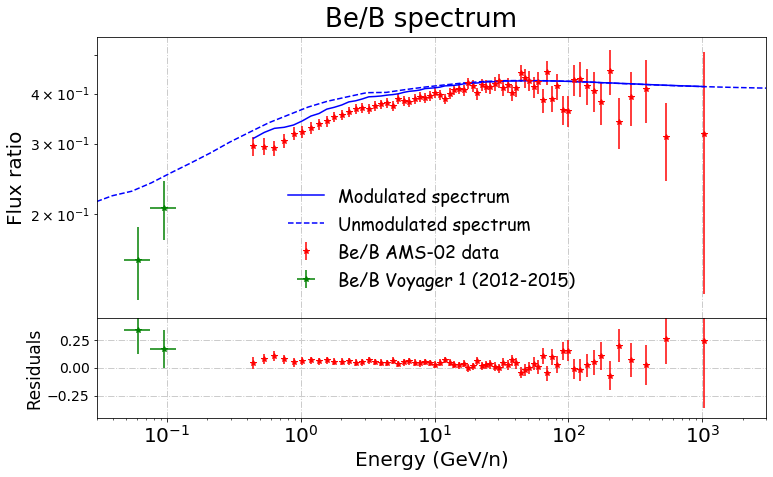

In [14]:
#PLOT BeB
fig1, (frame1,frame2)=plt.subplots(2, sharex='col', figsize=(12,7), gridspec_kw=gs_kw)
fig1.suptitle("Be/B spectrum", fontsize = 26, y=0.94)
    
fig1.subplots_adjust(hspace=0.)
frame1.set_yscale('log')
frame1.set_xscale('log', nonposx = 'clip')

frame1.errorbar(EmeanBeB, fluxBeB, yerr = [fluxBeB_low, fluxBeB_up], fmt='*r', label = "Be/B AMS-02 (2011-2016)") #Real data
frame1.errorbar(EmeanA, (fluxA/fluxA2_new), xerr = [Emean_min, Emean_max], yerr=fluxerr, fmt= '*g', label = "Be/B Voyager 1 (2012-2015)") #Real data

B10 = np.interp(EmeanBeB, E, CR.modul(E, np.array(table_B10)[0], 5, 10, phi_ams))
B11 = np.interp(EmeanBeB, E, CR.modul(E, np.array(table_B11)[0], 5, 11, phi_ams))

Be7 = np.interp(EmeanBeB, E, CR.modul(E, np.array(table_Be7)[0], 4, 7, phi_ams))
Be9 = np.interp(EmeanBeB, E, CR.modul(E, np.array(table_Be9)[0], 4, 9, phi_ams))
Be10 = np.interp(EmeanBeB, E, CR.modul(E, np.array(table_Be10)[0], 4, 10, phi_ams))

mod0 = (Be7 + Be9 + Be10)/(B10 + B11)
frame1.plot(EmeanBeB, mod0, "b-", label='Modulated spectrum')

mod1 = np.interp(E, E, (np.array(table_Be10) + np.array(table_Be9) + np.array(table_Be7))[0]/(np.array(table_B10) + np.array(table_B11))[0])
frame1.plot(E[E<1e3], mod1[E<1e3], "b--", label='Unmodulated spectrum')

frame1.set_ylabel("Flux ratio", fontsize = 20)
frame1.grid(color = '0.8', linestyle='-.', linewidth=1, axis = 'x')
frame1.yaxis.set_tick_params(labelsize = 14)
frame1.set_yticks([2e-1, 3e-1, 4e-1, 5.e-1])

frame1.legend(prop={'family': 'fantasy', 'size': 18}, frameon = False, loc = 'lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1)

diff = np.array(mod0-fluxBeB)
frame2.errorbar(EmeanBeB, diff/mod0, yerr = errfluxBeB/fluxBeB,  fmt= "r*")

mod1 = np.interp(EmeanA, E, mod1)
diff = np.array(mod1-(fluxA/fluxA2_new))
frame2.errorbar(EmeanA, diff/mod1, yerr = fluxerr/(fluxA/fluxA2_new), xerr = [Emean_min, Emean_max],  fmt= "g*")

frame2.set_ylabel("Residuals", fontsize = 17)
frame2.set_xlabel("Energy (GeV/n)", fontsize = 20)
frame2.grid(color = '0.8', linestyle='-.', linewidth=1)

frame1.set_ylim(bottom = 1.1e-1)
#frame1.set_xlim(left = 0.03, right = 3e3)
frame2.set_ylim(top = 0.45, bottom = -0.45)
frame2.set_xlim(right = 1.5e3, left = 0.03)

frame2.yaxis.set_tick_params(labelsize = 14)
frame2.xaxis.set_tick_params(labelsize = 20)

plt.savefig('C:/Users/pedro/OneDrive/Escritorio/BeB_spectrum_DRAGON2.png')
plt.savefig('C:/Users/pedro/OneDrive/Escritorio/BeB_spectrum_DRAGON2.pdf')
plt.show()
plt.close()

# Li/B

In [15]:
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/Li_B_ratio_AMS_PRL2018.txt'
EmeanLiB = np.loadtxt(data,skiprows=0,usecols=(0,))
fluxLiB, fluxLiB_low, fluxLiB_up = np.loadtxt(data,skiprows=0,usecols=(3, 4, 5), unpack=True)
errfluxLiB = (fluxLiB_low + fluxLiB_up)/2


MyZ = 5
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/BC/apjaa2409t9_ascii.txt' 
Z, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)
fluxA2, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)
EmeanA2 = (1e-3*(0.5*(Emean_min + Emean_max)))[Z ==MyZ]

errfluxA2 = (np.sqrt(sys**2 + sig**2))[Z==MyZ]
fluxA2 = 1e3*fluxA2[Z==MyZ]

errfluxA2 = (errfluxA2[EmeanA2 > 0.01])
fluxA2 = fluxA2[EmeanA2>0.01]

Emean_min = (1e-3 * Emean_min[Z==MyZ])[EmeanA2>0.01]
Emean_max = (1e-3 * Emean_max[Z==MyZ])[EmeanA2>0.01]

Emean_minA2 = EmeanA2[EmeanA2>0.01] - Emean_min
Emean_maxA2 = Emean_max - EmeanA2[EmeanA2>0.01] 

EmeanA2 = EmeanA2[EmeanA2>0.01]


MyZ = 3
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/BC/apjaa2409t9_ascii.txt' # ϕ=564 ± 26 MV
Z, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)
fluxA, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)
EmeanA = (1e-3*(0.5*(Emean_min + Emean_max)))[Z==MyZ]
errfluxA = 1e3*np.sqrt(sys**2 + sig**2)[Z==MyZ]
fluxA = 1e3*fluxA[Z==MyZ]

errfluxA = (errfluxA[EmeanA > 0.01])
fluxA = fluxA[EmeanA>0.01]
Emean_min = (1e-3 * Emean_min[Z==MyZ])[EmeanA>0.01]
Emean_max = (1e-3 * Emean_max[Z==MyZ])[EmeanA>0.01]

Emean_min = EmeanA[EmeanA>0.01] - Emean_min
Emean_max = Emean_max - EmeanA[EmeanA>0.01] 

EmeanA = EmeanA[EmeanA>0.01]
Etot = np.sort(list(EmeanBeB)+ list(EmeanA))

fluxA2_new = np.interp(EmeanA, EmeanA2, fluxA2)
errfluxA2_new = np.interp(EmeanA, EmeanA2, errfluxA2)

fluxerr = voyerr(fluxA, fluxA2_new, errfluxA, errfluxA2_new)

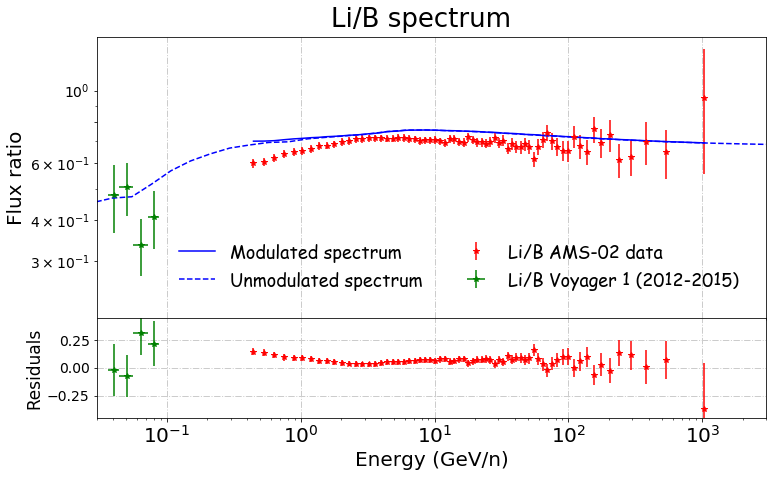

In [16]:
#PLOT LiB
fig1, (frame1,frame2)=plt.subplots(2, sharex='col', figsize=(12,7), gridspec_kw=gs_kw)
fig1.suptitle("Li/B spectrum", fontsize = 26, y=0.94)
    
fig1.subplots_adjust(hspace=0.)
frame1.set_yscale('log')
frame1.set_xscale('log', nonposx = 'clip')

frame1.errorbar(EmeanLiB, fluxLiB, yerr = [fluxLiB_low, fluxLiB_up], fmt='*r', label = "Li/B AMS-02 (2011-2016)") #Real data
frame1.errorbar(EmeanA, (fluxA/fluxA2_new), xerr = [Emean_min, Emean_max], yerr=fluxerr, fmt= '*g', label = "Li/B Voyager 1 (2012-2015)") #Real data

B10 = np.interp(EmeanLiB, E, CR.modul(E, np.array(table_B10)[0], 5, 10, phi_ams))
B11 = np.interp(EmeanLiB, E, CR.modul(E, np.array(table_B11)[0], 5, 11, phi_ams))

Li6 = np.interp(EmeanLiB, E, CR.modul(E, np.array(table_Li6)[0], 3, 6, phi_ams))
Li7 = np.interp(EmeanLiB, E, CR.modul(E, np.array(table_Li7)[0], 3, 7, phi_ams))

mod0 = (Li6 + Li7)/(B10 + B11)
frame1.plot(EmeanLiB, mod0, "b-", label='Modulated spectrum')

mod1 = np.interp(E[E<1e3], E[E<1e3], (np.array(table_Li7) + np.array(table_Li6))[0]/(np.array(table_B10) + np.array(table_B11))[0])
frame1.plot(E, mod1, "b--", label='Unmodulated spectrum')

frame1.set_ylabel("Flux ratio", fontsize = 20)
frame1.grid(color = '0.8', linestyle='-.', linewidth=1, axis = 'x')
frame1.yaxis.set_tick_params(labelsize = 14)
frame1.set_yticks([0.3, 0.4, 0.6, 0.8, 1])

frame1.legend(prop={'family': 'fantasy', 'size': 18}, frameon = False, loc = 'lower right', ncol=2, fancybox=True, framealpha=1, shadow=True, borderpad=1)

diff = np.array(mod0-fluxLiB)
frame2.errorbar(EmeanLiB, diff/mod0, yerr = errfluxLiB/fluxLiB,  fmt= "r*")

mod1 = np.interp(EmeanA, E, mod1)
diff = np.array(mod1-(fluxA/fluxA2_new))
frame2.errorbar(EmeanA, diff/mod1, yerr = fluxerr/(fluxA/fluxA2_new), xerr = [Emean_min, Emean_max],  fmt= "g*")

frame2.set_ylabel("Residuals", fontsize = 17)
frame2.set_xlabel("Energy (GeV/n)", fontsize = 20)
frame2.grid(color = '0.8', linestyle='-.', linewidth=1)

frame1.set_ylim(bottom = 2.01e-1)
#frame1.set_xlim(left = 0.03, right = 3e3)
frame2.set_ylim(top = 0.45, bottom = -0.45)
frame2.set_xlim(right = 1.5e3, left = 0.03)

frame2.yaxis.set_tick_params(labelsize = 14)
frame2.xaxis.set_tick_params(labelsize = 20)

plt.savefig('C:/Users/pedro/OneDrive/Escritorio/LiB_spectrum_DRAGON2.png')
plt.savefig('C:/Users/pedro/OneDrive/Escritorio/LiB_spectrum_DRAGON2.pdf')
plt.show()
plt.close()

# Li/Be

In [17]:
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/nuclei1/Be_AMS_PRL2018.txt' # ϕ=564 ± 26 MV
EmeanBe, EmeanBe_low, EmeanBe_up = np.loadtxt(data,skiprows=0,usecols=(0, 1, 2), unpack=True)
fluxBe, fluxBe_low, fluxBe_up = np.loadtxt(data,skiprows=0,usecols=(3, 4, 5), unpack=True)
errfluxBe = (fluxBe_low + fluxBe_up)/2

data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/nuclei1/Li_AMS_PRL2018.txt' # ϕ=564 ± 26 MV
EmeanLi, EmeanLi_low, EmeanLi_up = np.loadtxt(data,skiprows=0,usecols=(0, 1, 2), unpack=True)
fluxLi, fluxLi_low, fluxLi_up = np.loadtxt(data,skiprows=0,usecols=(3, 4, 5), unpack=True)
errfluxLi = (fluxLi_low + fluxLi_up)/2

fluxLi = np.interp(EmeanBe, EmeanLi, fluxLi)
errfluxLi = np.interp(EmeanBe, EmeanLi, errfluxLi)
errfluxLiBe = np.sqrt((errfluxLi/fluxBe)**2 + (errfluxBe * (fluxLi/(fluxBe)**2))**2)
fluxLiBe = fluxLi/fluxBe
EmeanLiBe = EmeanBe


MyZ = 4
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/BC/apjaa2409t9_ascii.txt' 
Z, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)
fluxA2, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)
EmeanA2 = (1e-3*(0.5*(Emean_min + Emean_max)))[Z ==MyZ]

errfluxA2 = (np.sqrt(sys**2 + sig**2))[Z==MyZ]
fluxA2 = 1e3*fluxA2[Z==MyZ]

errfluxA2 = (errfluxA2[EmeanA2 > 0.01])
fluxA2 = fluxA2[EmeanA2>0.01]

Emean_min = (1e-3 * Emean_min[Z==MyZ])[EmeanA2>0.01]
Emean_max = (1e-3 * Emean_max[Z==MyZ])[EmeanA2>0.01]

Emean_minA2 = EmeanA2[EmeanA2>0.01] - Emean_min
Emean_maxA2 = Emean_max - EmeanA2[EmeanA2>0.01] 

EmeanA2 = EmeanA2[EmeanA2>0.01]


MyZ = 3
data = 'C:/Users/pedro/OneDrive/Escritorio/PhD_INFN_U.B/thesis_work/data_files/BC/apjaa2409t9_ascii.txt' # ϕ=564 ± 26 MV
Z, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)
fluxA, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)
EmeanA = (1e-3*(0.5*(Emean_min + Emean_max)))[Z==MyZ]
errfluxA = 1e3*np.sqrt(sys**2 + sig**2)[Z==MyZ]
fluxA = 1e3*fluxA[Z==MyZ]

errfluxA = (errfluxA[EmeanA > 0.01])
fluxA = fluxA[EmeanA>0.01]
Emean_min = (1e-3 * Emean_min[Z==MyZ])[EmeanA>0.01]
Emean_max = (1e-3 * Emean_max[Z==MyZ])[EmeanA>0.01]

Emean_min = EmeanA[EmeanA>0.01] - Emean_min
Emean_max = Emean_max - EmeanA[EmeanA>0.01] 

EmeanA = EmeanA[EmeanA>0.01]
Etot = np.sort(list(EmeanBeB)+ list(EmeanA))

fluxA2_new = np.interp(EmeanA, EmeanA2, fluxA2)
errfluxA2_new = np.interp(EmeanA, EmeanA2, errfluxA2)

fluxerr = voyerr(fluxA, fluxA2_new, errfluxA, errfluxA2_new)

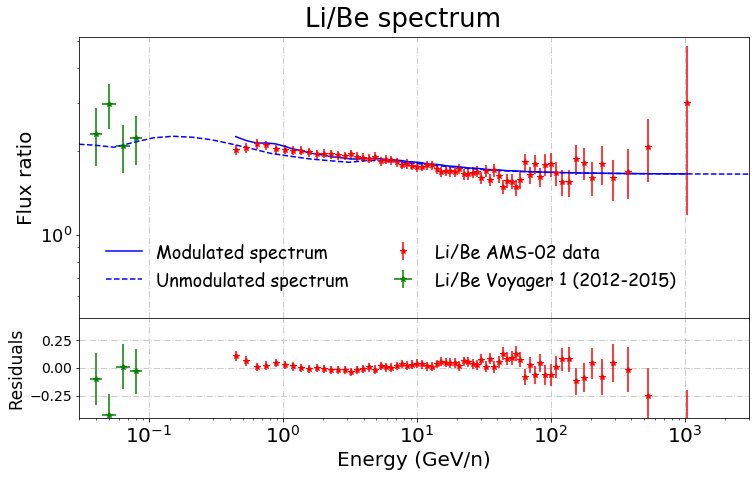

In [18]:
#PLOT LiB
fig1, (frame1,frame2)=plt.subplots(2, sharex='col', figsize=(12,7), gridspec_kw=gs_kw)
fig1.suptitle("Li/Be spectrum", fontsize = 26, y=0.94)
    
fig1.subplots_adjust(hspace=0.)
frame1.set_yscale('log')
frame1.set_xscale('log', nonposx = 'clip')

frame1.errorbar(EmeanLiBe, fluxLiBe, yerr = errfluxLiBe, fmt='*r', label = "Li/Be AMS-02 (2011-2016)") #Real data
frame1.errorbar(EmeanA, (fluxA/fluxA2_new), xerr = [Emean_min, Emean_max], yerr=fluxerr, fmt= '*g', label = "Li/Be Voyager 1 (2012-2015)") #Real data

Li6 = np.interp(EmeanLiB, E, CR.modul(E, np.array(table_Li6)[0], 3, 6, phi_ams))
Li7 = np.interp(EmeanLiB, E, CR.modul(E, np.array(table_Li7)[0], 3, 7, phi_ams))

Be7 = np.interp(EmeanBeB, E, CR.modul(E, np.array(table_Be7)[0], 4, 7, phi_ams))
Be9 = np.interp(EmeanBeB, E, CR.modul(E, np.array(table_Be9)[0], 4, 9, phi_ams))
Be10 = np.interp(EmeanBeB, E, CR.modul(E, np.array(table_Be10)[0], 4, 10, phi_ams))

mod0 = (Li6 + Li7)/(Be7 + Be9 + Be10)
frame1.plot(EmeanLiB, mod0, "b-", label='Modulated spectrum')

mod1 = np.interp(E[E<1e3], E[E<1e3], (np.array(table_Li7) + np.array(table_Li6))[0]/np.interp(E, E, (np.array(table_Be10) + np.array(table_Be9) + np.array(table_Be7))[0]))
frame1.plot(E, mod1, "b--", label='Unmodulated spectrum')

frame1.set_ylabel("Flux ratio", fontsize = 20)
frame1.grid(color = '0.8', linestyle='-.', linewidth=1, axis = 'x')
frame1.yaxis.set_tick_params(labelsize = 18)
#frame1.set_yticks([1.1, 2.])

frame1.legend(prop={'family': 'fantasy', 'size': 18}, frameon = False, loc = 'lower left', ncol = 2, fancybox=True, framealpha=1, shadow=True, borderpad=1)

diff = np.array(mod0-fluxLiBe)
frame2.errorbar(EmeanLiBe, diff/mod0, yerr = errfluxLiBe/fluxLiBe,  fmt= "r*")

mod1 = np.interp(EmeanA, E, mod1)
diff = np.array(mod1-(fluxA/fluxA2_new))
frame2.errorbar(EmeanA, diff/mod1, yerr = fluxerr/(fluxA/fluxA2_new), xerr = [Emean_min, Emean_max],  fmt= "g*")

frame2.set_ylabel("Residuals", fontsize = 17)
frame2.set_xlabel("Energy (GeV/n)", fontsize = 20)
frame2.grid(color = '0.8', linestyle='-.', linewidth=1)

frame1.set_ylim(bottom = 5.01e-1)
#frame1.set_xlim(left = 0.03, right = 3e3)
frame2.set_ylim(top = 0.45, bottom = -0.45)
frame2.set_xlim(right = 1.5e3, left = 0.03)

frame2.yaxis.set_tick_params(labelsize = 14)
frame2.xaxis.set_tick_params(labelsize = 20)

plt.savefig('C:/Users/pedro/OneDrive/Escritorio/LiBe_spectrum_DRAGON2.png')
plt.savefig('C:/Users/pedro/OneDrive/Escritorio/LiBe_spectrum_DRAGON2.pdf')
plt.show()
plt.close()